# Clases y funciones

## Clases

## Funciones

### Función GridSearch con Balanceo

### Función impresión de resultados

# Cargar librerias y dataset

## Cargar librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, 
    roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import pickle
from enum import Enum
import os
os.chdir("D:/Users/Jose Castro/Desktop/FINAL NO COUNTRY/c21-47-ft-data-bi")

In [2]:
class SamplingMethod(Enum):
    UNDERSAMPLING = 1
    NONE = 3

In [3]:
def plot_class_distribution(y, title='Distribución de Clases'):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel('Clase')
    plt.ylabel('Frecuencia')
    plt.xticks(ticks=[0, 1], labels=['No Fraud', 'Fraud'])
    plt.show()

In [4]:
def plot_confusion_matrix(cm, title='Matriz de Confusión', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Fraud', 'Fraud'], rotation=45)
    plt.yticks(tick_marks, ['No Fraud', 'Fraud'])

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.tight_layout()

In [5]:
def plot_roc_curve(fpr, tpr, auc, title='Curva ROC'):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (Área = {:.2f})'.format(auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()

In [6]:
def print_results(results, model_name, balance_type, random_seed):
    if isinstance(results, tuple) and len(results) == 7:
        accuracy, precision, recall, f1, roc_auc, best_params, model = results
        print(f"  {model_name} - {balance_type} (Semilla {random_seed})")
        print(f"    Accuracy: {accuracy}")
        print(f"    Precision: {precision}")
        print(f"    Recall: {recall}")
        print(f"    F1 Score: {f1}")
        print(f"    ROC-AUC: {roc_auc}")
        print(f"    Best Parameters: {best_params}")

        # Guardar el modelo entrenado
        model_filename = f"model_{model_name}_{balance_type}_seed_{random_seed}.pkl"
        with open(model_filename, "wb") as file:
            pickle.dump(model, file)
        print(f"Modelo guardado como {model_filename}")
    else:
        print(f"Formato desconocido de resultados para {model_name} - {balance_type} (Semilla {random_seed})")


In [7]:
def grid_search_with_and_without_balance(model, param_grid, X_train, y_train, X_eval, y_eval, X_test, y_test, sampler=None, random_seed=None, balance_type=None):
    """
    Optimiza los hiperparámetros de un modelo con opciones para balancear las clases.
    """
    print(f"\n--> Iniciando {balance_type} para {model.__class__.__name__} con semilla {random_seed}")

    # Aplicar balanceo solo si el modelo no admite scale_pos_weight
    if balance_type == 'undersampling' and sampler == SamplingMethod.UNDERSAMPLING:
        sampler = RandomUnderSampler(random_state=random_seed)
        print(f"Tamaño original de X_train: {X_train.shape}, y_train: {y_train.shape}")
        plot_class_distribution(y_train, title='Distribución de Clases - Antes de Undersampling')
        X_train, y_train = sampler.fit_resample(X_train, y_train)
        print(f"Tamaño después de undersampling de X_train: {X_train.shape}, y_train: {y_train.shape}")
        plot_class_distribution(y_train, title='Distribución de Clases - Después de Undersampling')

    # Realizar la búsqueda en cuadrícula
    grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=5)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    # Ajustar el modelo con los mejores parámetros
    model.set_params(**best_params)
    model.fit(X_train, y_train)

    # Evaluación en el conjunto de validación
    print(f"\nEvaluación en el conjunto de validación para {model.__class__.__name__} - Semilla {random_seed}")
    y_val_pred = model.predict(X_eval)
    y_val_pred_prob = model.predict_proba(X_eval)[:, 1]
    val_accuracy = accuracy_score(y_eval, y_val_pred)
    val_precision = precision_score(y_eval, y_val_pred)
    val_recall = recall_score(y_eval, y_val_pred)
    val_f1 = f1_score(y_eval, y_val_pred)
    val_roc_auc = roc_auc_score(y_eval, y_val_pred)

    print_results((val_accuracy, val_precision, val_recall, val_f1, val_roc_auc, best_params, model), model.__class__.__name__, balance_type, random_seed)
    cm = confusion_matrix(y_eval, y_val_pred)
    plot_confusion_matrix(cm, title=f'Matriz de Confusión - Validación - {model.__class__.__name__} - Semilla {random_seed}')
    fpr, tpr, _ = roc_curve(y_eval, y_val_pred_prob)
    plot_roc_curve(fpr, tpr, val_roc_auc, title=f'Curva ROC - Validación - {model.__class__.__name__} - Semilla {random_seed}')
    plt.show()

    # Evaluación final en el conjunto de prueba
    print(f"\nEvaluación final en el conjunto de prueba para {model.__class__.__name__} - Semilla {random_seed}")
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    test_roc_auc = roc_auc_score(y_test, y_pred)

    print_results((test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, best_params, model), model.__class__.__name__, balance_type, random_seed)
    cm_test = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm_test, title=f'Matriz de Confusión - Prueba - {model.__class__.__name__} - Semilla {random_seed}')
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob)
    plot_roc_curve(fpr_test, tpr_test, test_roc_auc, title=f'Curva ROC - Prueba - {model.__class__.__name__} - Semilla {random_seed}')
    plt.show()

    return test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, best_params, model


## Cargar dataset

In [8]:
url= "data\intermediate\data_final_0"

data = pd.read_feather(url)
data_copy = data.copy()

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Jose Castro\AppData\Local\Temp\ipykernel_31352\3553701664.py:1: SyntaxWarning: invalid escape sequence '\i'
  url= "data\intermediate\data_final_0"


In [9]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 5 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   amt                     1296675 non-null  float64
 1   amount_per_transaction  1296675 non-null  float64
 2   age_amount_interaction  1296675 non-null  float64
 3   job_encoded             1296675 non-null  float64
 4   is_fraud                1296675 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 49.5 MB


# Modelo Machine Learning

## Defenir features y target

In [10]:
features = data_copy.drop(["is_fraud"], axis=1)
target = data_copy.is_fraud

## Separar características numéricas y categóricas

In [11]:
numeric_features = features.select_dtypes(include=['number']).columns.tolist()
categorical_features = features.select_dtypes(include=['object']).columns.tolist()

## Creación del preprocesador

In [12]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## Inicializar el Diccionario para Almacenar Resultados

In [13]:
results_by_seed = {}
models_by_seed = {}
seed_list = [42,15,1235,10101101]  # Puedes agregar más semillas aquí

best_global_f1 = -1
best_global_model = None
best_global_approach = None
best_global_seed = None
best_global_params = None
best_models_by_approach = {
    #'weighted': {'model': None, 'params': None, 'f1': -1},
    'undersampling': {'model': None, 'params': None, 'f1': -1}
    #'oversampling': {'model': None, 'params': None, 'f1': -1},
    #'unbalanced': {'model': None, 'params': None, 'f1': -1}
}

## Lista de modelos y parámetros a probar


--> Iniciando undersampling para LogisticRegression con semilla 42
Tamaño original de X_train: (778005, 4), y_train: (778005,)


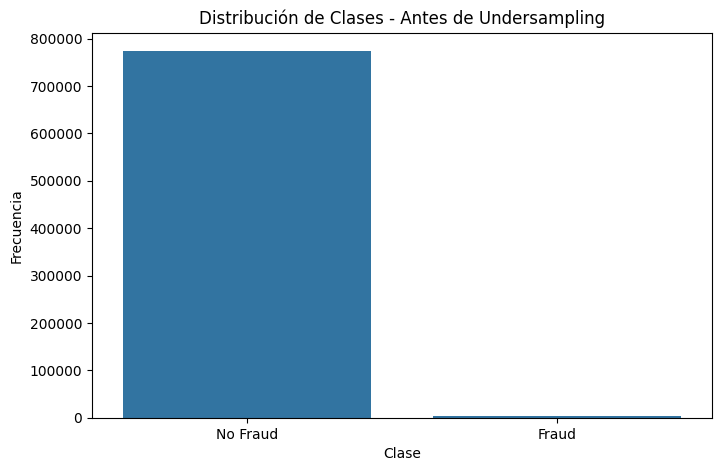

Tamaño después de undersampling de X_train: (8894, 4), y_train: (8894,)


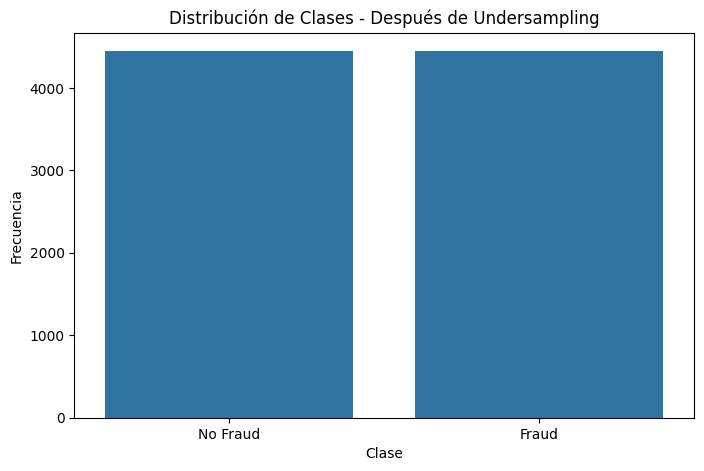


Evaluación en el conjunto de validación para LogisticRegression - Semilla 42
  LogisticRegression - undersampling (Semilla 42)
    Accuracy: 0.9573061869782328
    Precision: 0.10009228962161255
    Recall: 0.7751786874593892
    F1 Score: 0.17729231683756874
    ROC-AUC: 0.8667860729264238
    Best Parameters: {'C': 0.01}
Modelo guardado como model_LogisticRegression_undersampling_seed_42.pkl


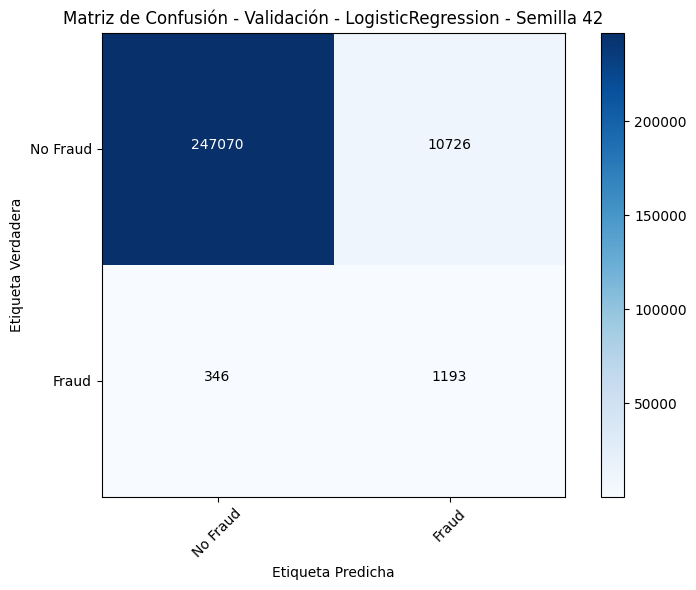

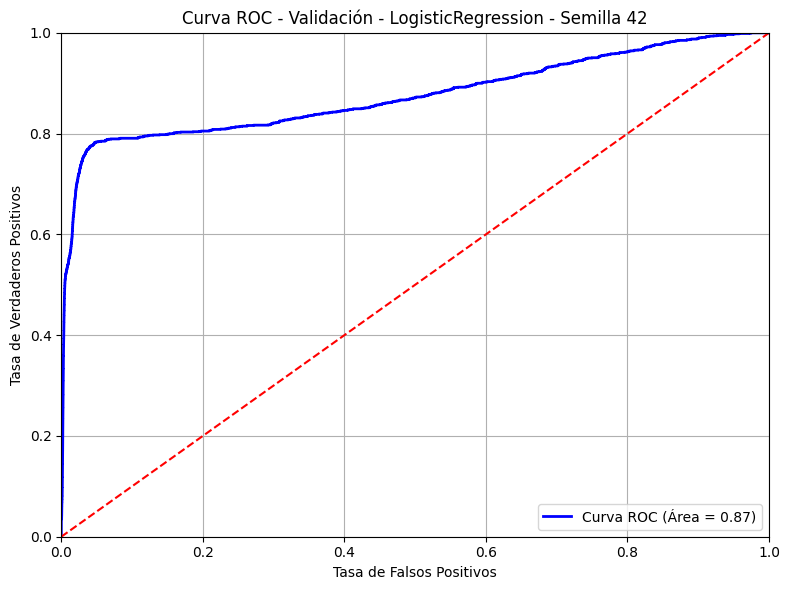


Evaluación final en el conjunto de prueba para LogisticRegression - Semilla 42
  LogisticRegression - undersampling (Semilla 42)
    Accuracy: 0.9571558023406019
    Precision: 0.09913901195352337
    Recall: 0.7802631578947369
    F1 Score: 0.17592523919009123
    ROC-AUC: 0.8692309331354491
    Best Parameters: {'C': 0.01}
Modelo guardado como model_LogisticRegression_undersampling_seed_42.pkl


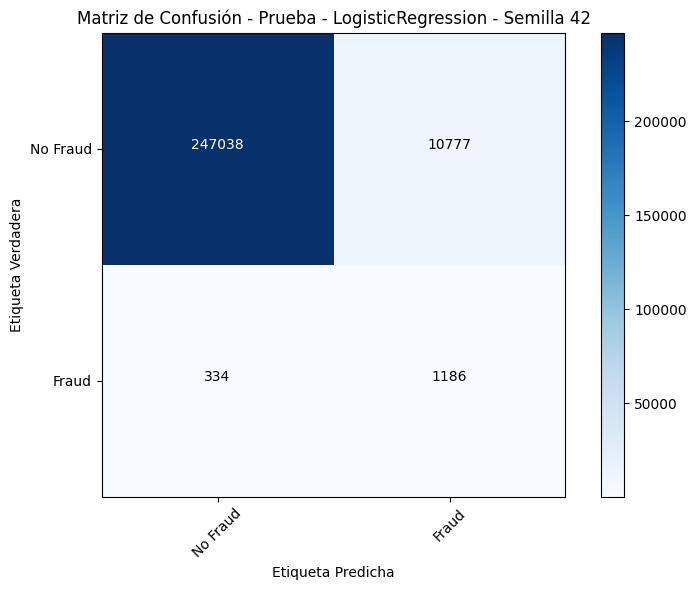

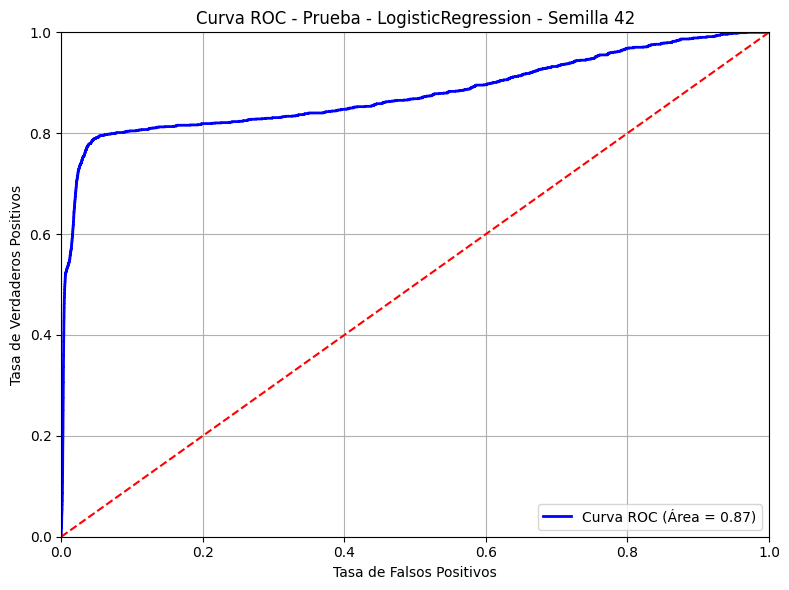

  LogisticRegression - undersampling (Semilla 42)
    Accuracy: 0.9571558023406019
    Precision: 0.09913901195352337
    Recall: 0.7802631578947369
    F1 Score: 0.17592523919009123
    ROC-AUC: 0.8692309331354491
    Best Parameters: {'C': 0.01}
Modelo guardado como model_LogisticRegression_undersampling_seed_42.pkl

--> Iniciando undersampling para DecisionTreeClassifier con semilla 42
Tamaño original de X_train: (778005, 4), y_train: (778005,)


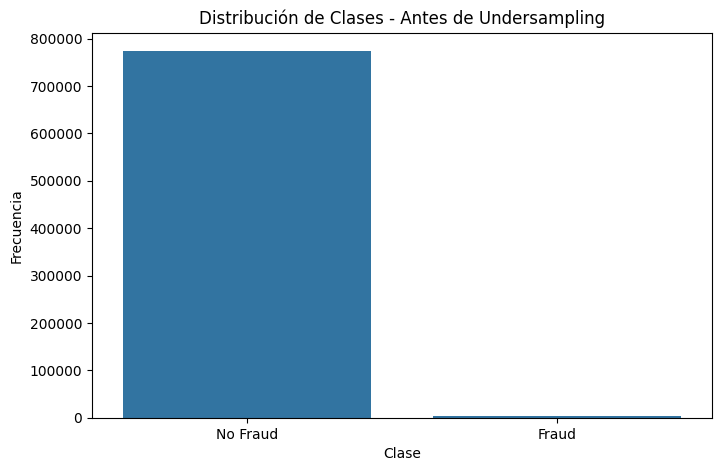

Tamaño después de undersampling de X_train: (8894, 4), y_train: (8894,)


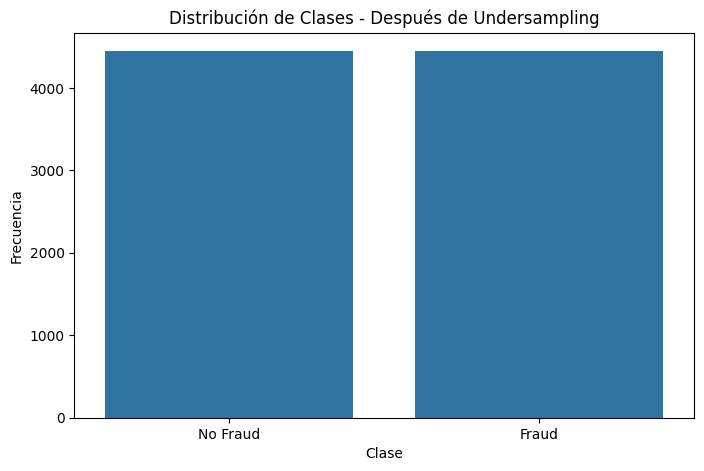


Evaluación en el conjunto de validación para DecisionTreeClassifier - Semilla 42
  DecisionTreeClassifier - undersampling (Semilla 42)
    Accuracy: 0.9076638324946498
    Precision: 0.053485313459009205
    Recall: 0.8719948018193632
    F1 Score: 0.1007885843034172
    ROC-AUC: 0.88993578629968
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Modelo guardado como model_DecisionTreeClassifier_undersampling_seed_42.pkl


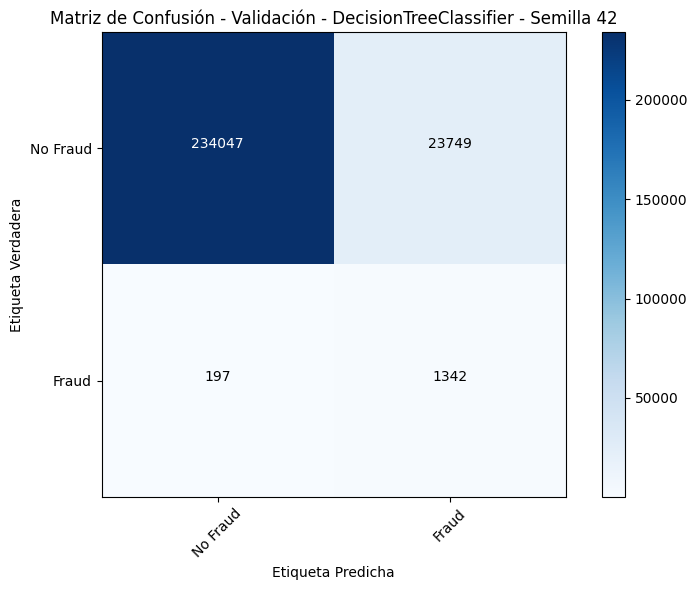

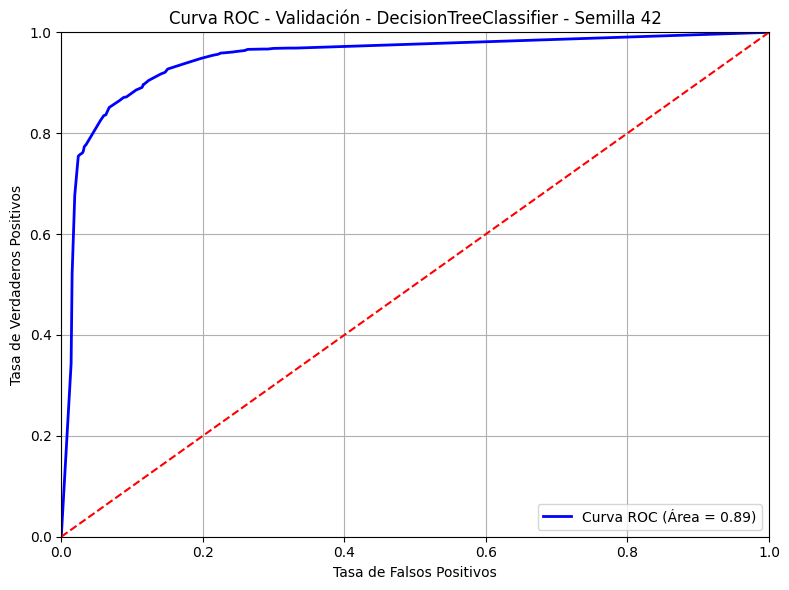


Evaluación final en el conjunto de prueba para DecisionTreeClassifier - Semilla 42
  DecisionTreeClassifier - undersampling (Semilla 42)
    Accuracy: 0.9070854300422234
    Precision: 0.05337500989158819
    Recall: 0.8875
    F1 Score: 0.10069418526535792
    ROC-AUC: 0.8973504499350309
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Modelo guardado como model_DecisionTreeClassifier_undersampling_seed_42.pkl


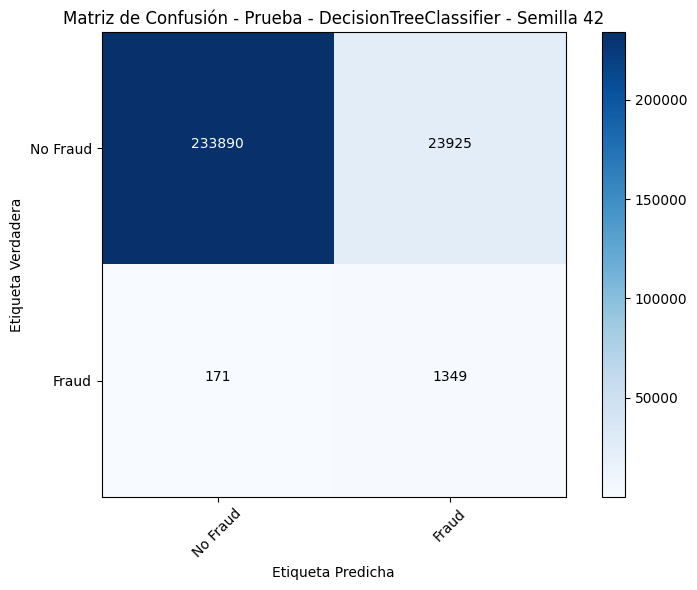

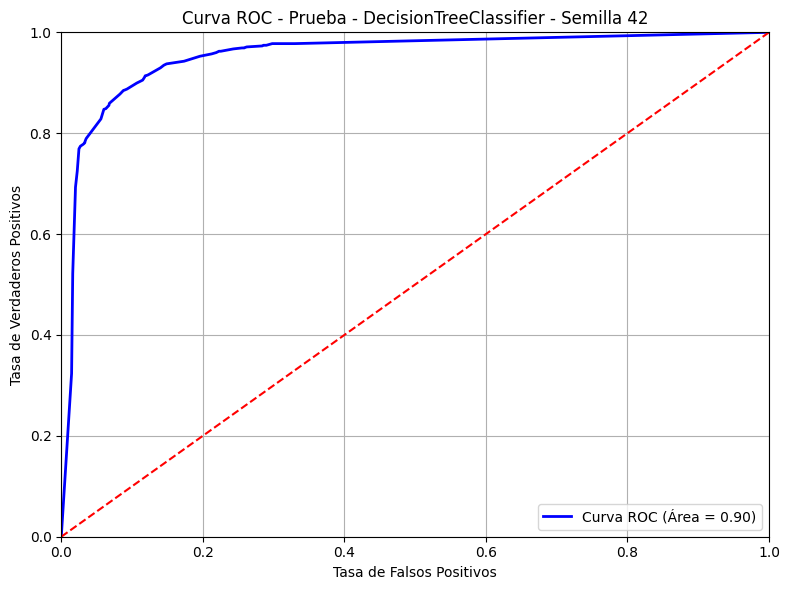

  DecisionTreeClassifier - undersampling (Semilla 42)
    Accuracy: 0.9070854300422234
    Precision: 0.05337500989158819
    Recall: 0.8875
    F1 Score: 0.10069418526535792
    ROC-AUC: 0.8973504499350309
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Modelo guardado como model_DecisionTreeClassifier_undersampling_seed_42.pkl

--> Iniciando undersampling para RandomForestClassifier con semilla 42
Tamaño original de X_train: (778005, 4), y_train: (778005,)


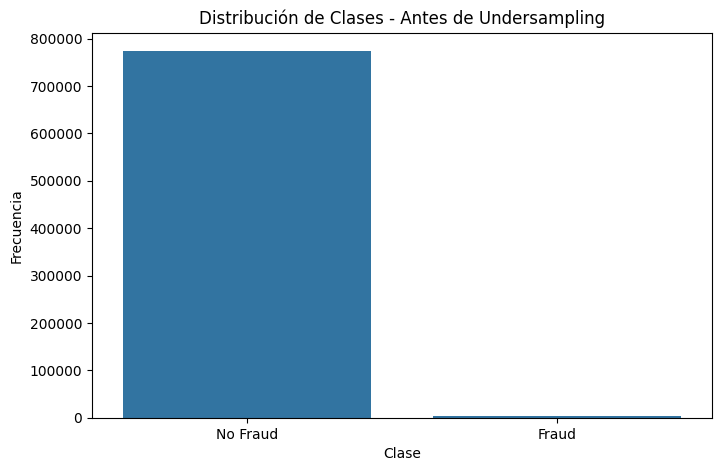

Tamaño después de undersampling de X_train: (8894, 4), y_train: (8894,)


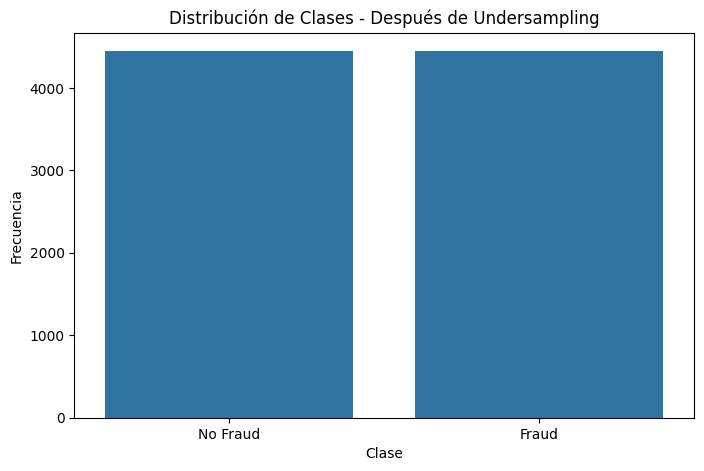


Evaluación en el conjunto de validación para RandomForestClassifier - Semilla 42
  RandomForestClassifier - undersampling (Semilla 42)
    Accuracy: 0.9109298783426841
    Precision: 0.056889181190397896
    Recall: 0.8992852501624431
    F1 Score: 0.10700893029728999
    ROC-AUC: 0.9051423225164028
    Best Parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Modelo guardado como model_RandomForestClassifier_undersampling_seed_42.pkl


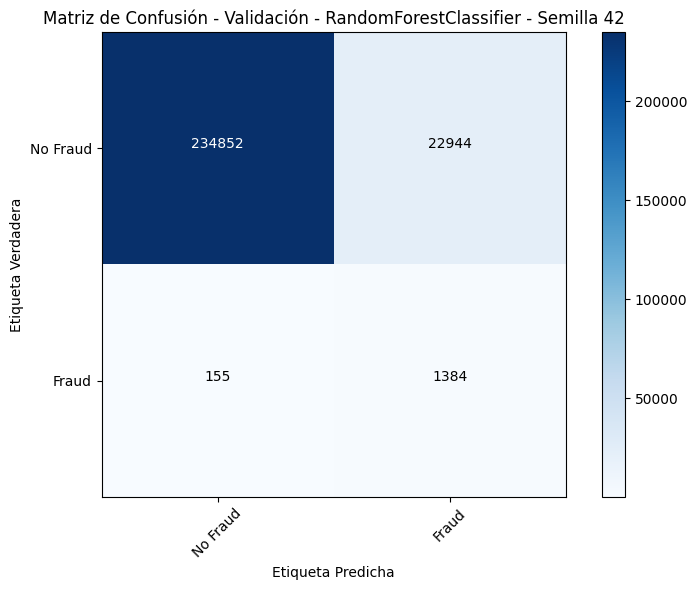

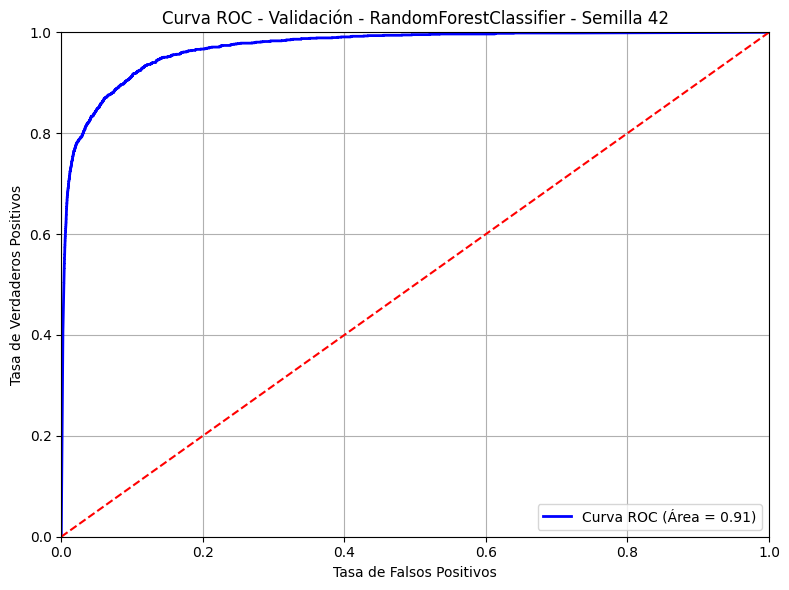


Evaluación final en el conjunto de prueba para RandomForestClassifier - Semilla 42
  RandomForestClassifier - undersampling (Semilla 42)
    Accuracy: 0.9128386064356913
    Precision: 0.05754218081087887
    Recall: 0.9019736842105263
    F1 Score: 0.1081827507298982
    ROC-AUC: 0.9074381734862922
    Best Parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Modelo guardado como model_RandomForestClassifier_undersampling_seed_42.pkl


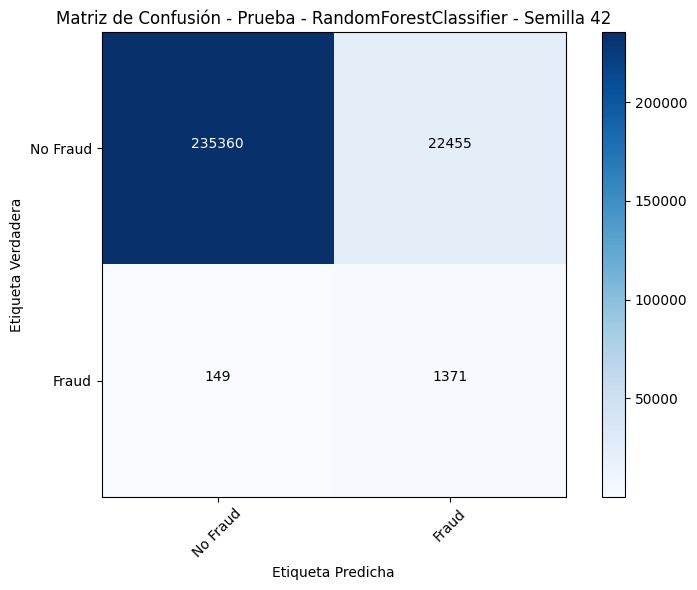

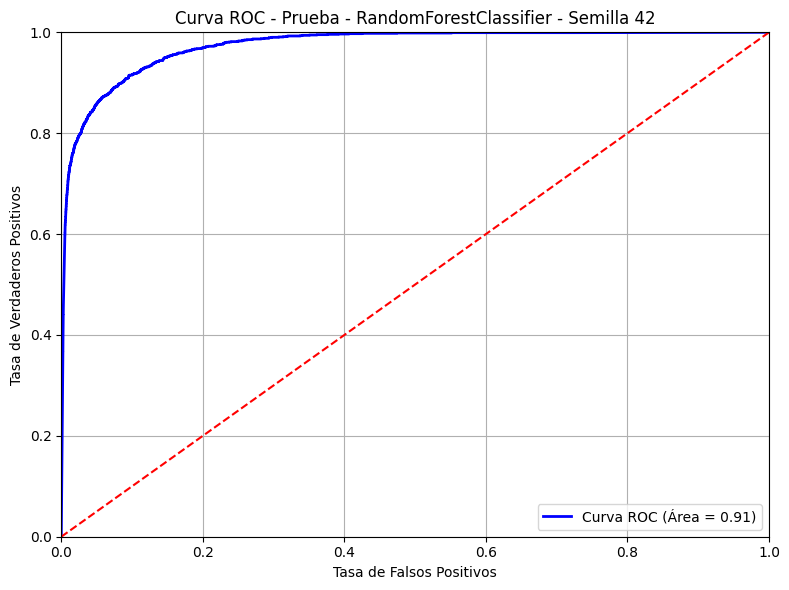

  RandomForestClassifier - undersampling (Semilla 42)
    Accuracy: 0.9128386064356913
    Precision: 0.05754218081087887
    Recall: 0.9019736842105263
    F1 Score: 0.1081827507298982
    ROC-AUC: 0.9074381734862922
    Best Parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Modelo guardado como model_RandomForestClassifier_undersampling_seed_42.pkl

--> Iniciando undersampling para LGBMClassifier con semilla 42
Tamaño original de X_train: (778005, 4), y_train: (778005,)


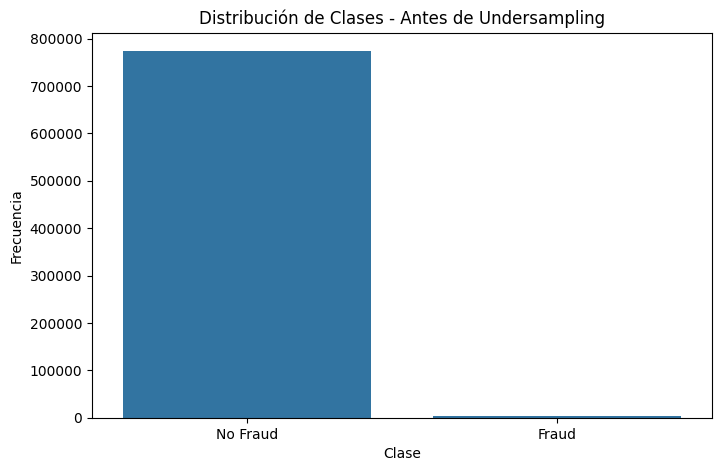

Tamaño después de undersampling de X_train: (8894, 4), y_train: (8894,)


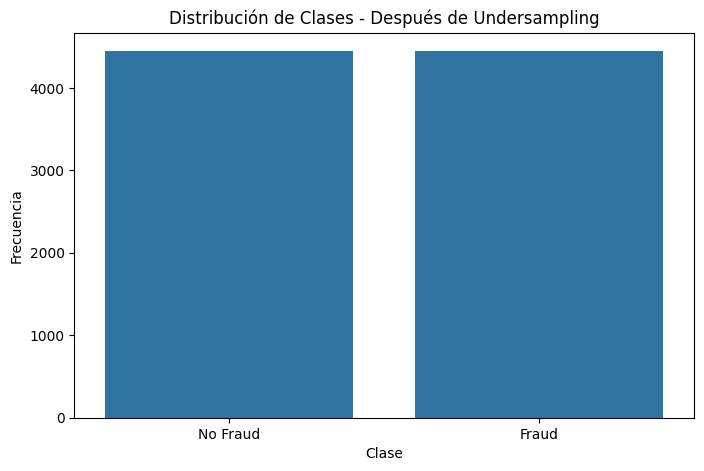

[LightGBM] [Info] Number of positive: 3558, number of negative: 3557
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 7115, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500070 -> initscore=0.000281
[LightGBM] [Info] Start training from score 0.000281
[LightGBM] [Info] Number of positive: 3558, number of negative: 3557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 7115, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500070 -> initscore=0.000281
[LightGBM] [I

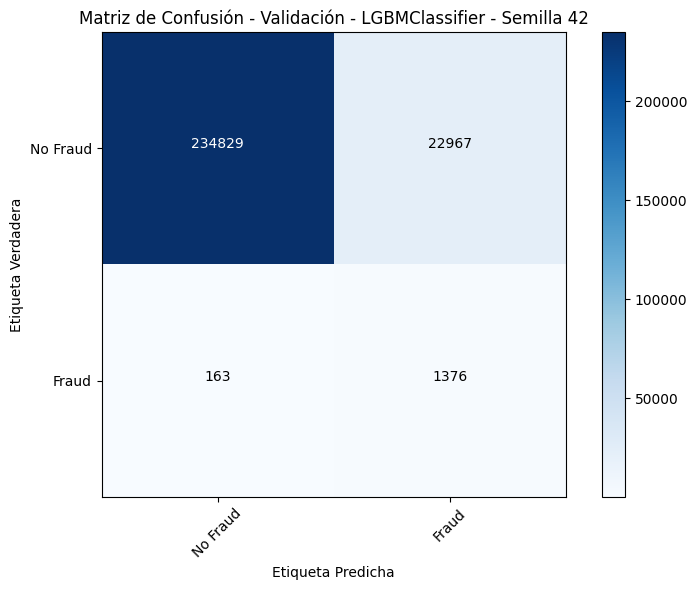

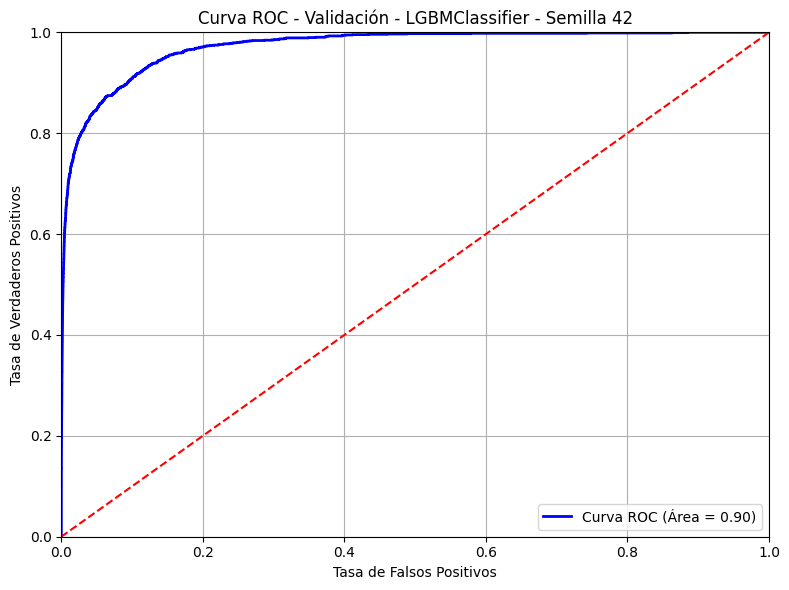


Evaluación final en el conjunto de prueba para LGBMClassifier - Semilla 42
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
  LGBMClassifier - undersampling (Semilla 42)
    Accuracy: 0.9122023637380222
    Precision: 0.057072580981364904
    Recall: 0.9006578947368421
    F1 Score: 0.10734308229113576
    ROC-AUC: 0.9064641606027171
    Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 31, 'scale_pos_weight': 1}
Modelo guardado como model_LGBMClassifier_undersampling_seed_42.pkl


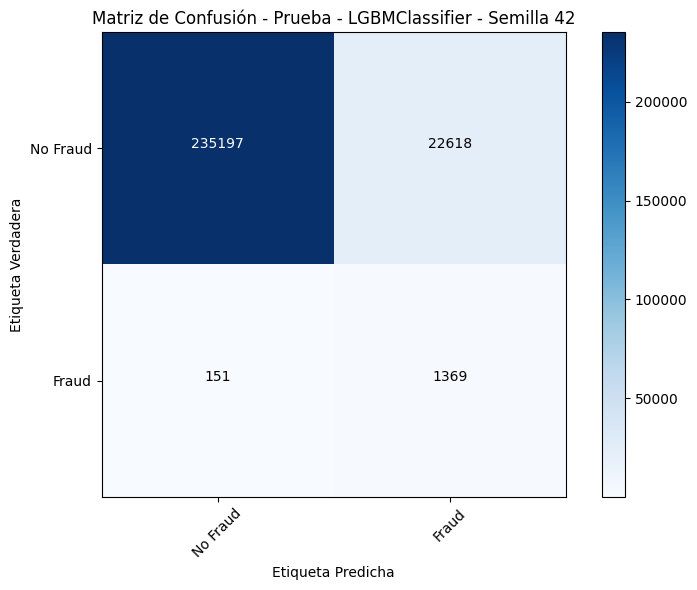

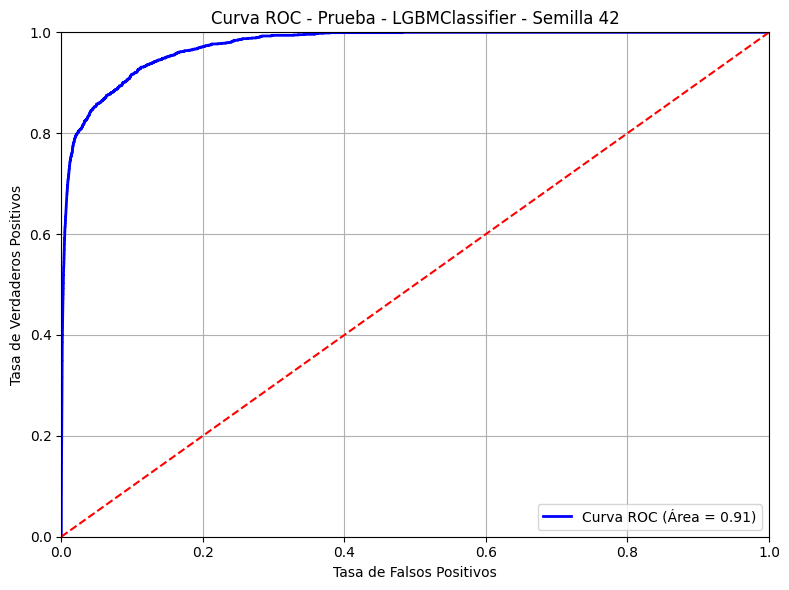

  LGBMClassifier - undersampling (Semilla 42)
    Accuracy: 0.9122023637380222
    Precision: 0.057072580981364904
    Recall: 0.9006578947368421
    F1 Score: 0.10734308229113576
    ROC-AUC: 0.9064641606027171
    Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 31, 'scale_pos_weight': 1}
Modelo guardado como model_LGBMClassifier_undersampling_seed_42.pkl

--> Iniciando undersampling para XGBClassifier con semilla 42
Tamaño original de X_train: (778005, 4), y_train: (778005,)


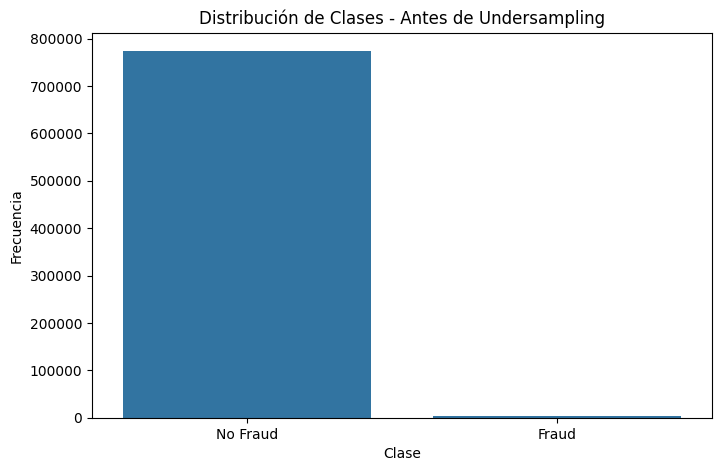

Tamaño después de undersampling de X_train: (8894, 4), y_train: (8894,)


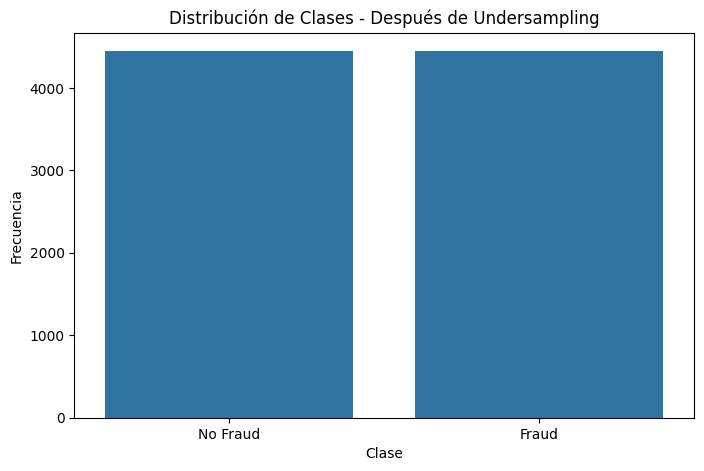


Evaluación en el conjunto de validación para XGBClassifier - Semilla 42
  XGBClassifier - undersampling (Semilla 42)
    Accuracy: 0.9129967031060212
    Precision: 0.05805936265029849
    Recall: 0.8973359324236517
    F1 Score: 0.10906219151036525
    ROC-AUC: 0.9052130638859558
    Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1}
Modelo guardado como model_XGBClassifier_undersampling_seed_42.pkl


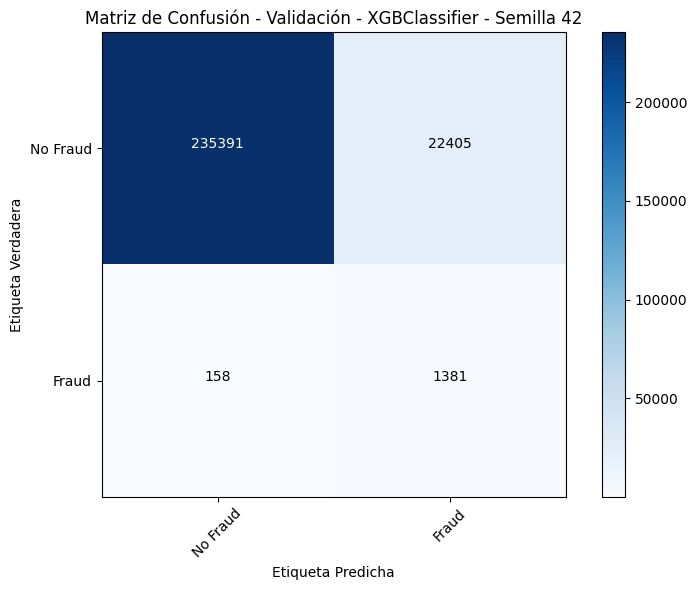

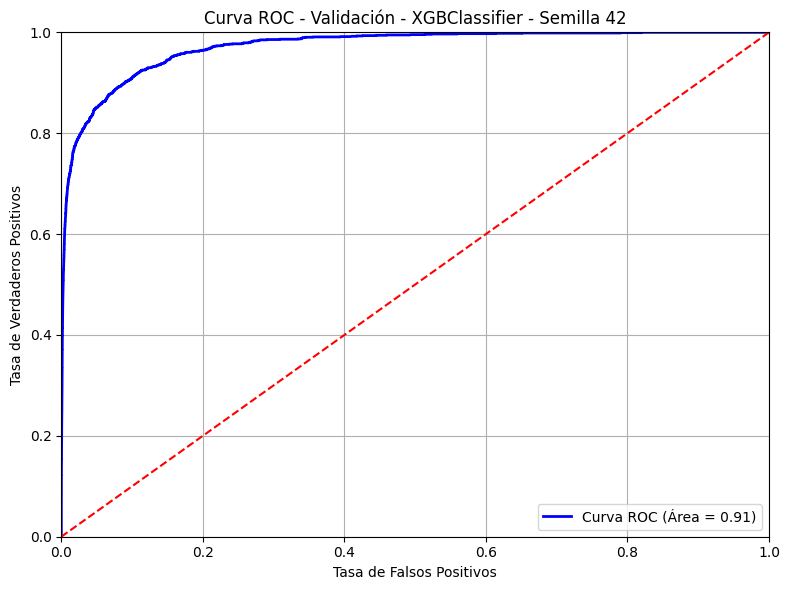


Evaluación final en el conjunto de prueba para XGBClassifier - Semilla 42
  XGBClassifier - undersampling (Semilla 42)
    Accuracy: 0.9154799776351051
    Precision: 0.05916929593292129
    Recall: 0.9006578947368421
    F1 Score: 0.11104351705398062
    ROC-AUC: 0.9081126294660492
    Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1}
Modelo guardado como model_XGBClassifier_undersampling_seed_42.pkl


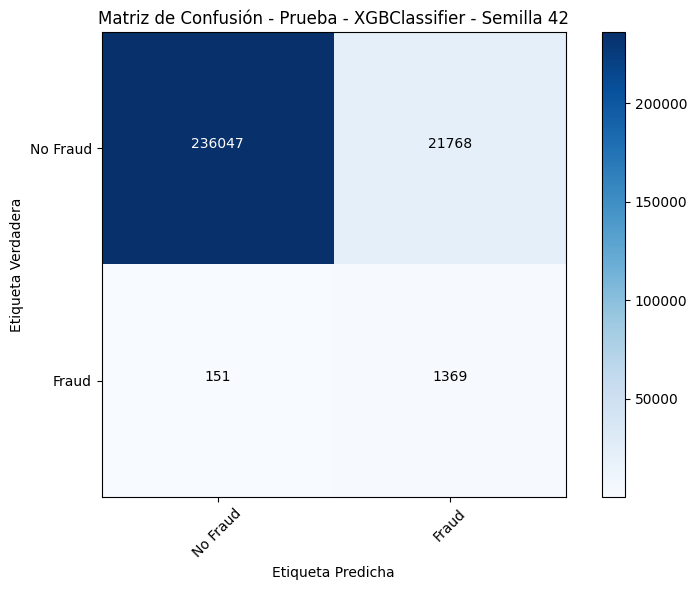

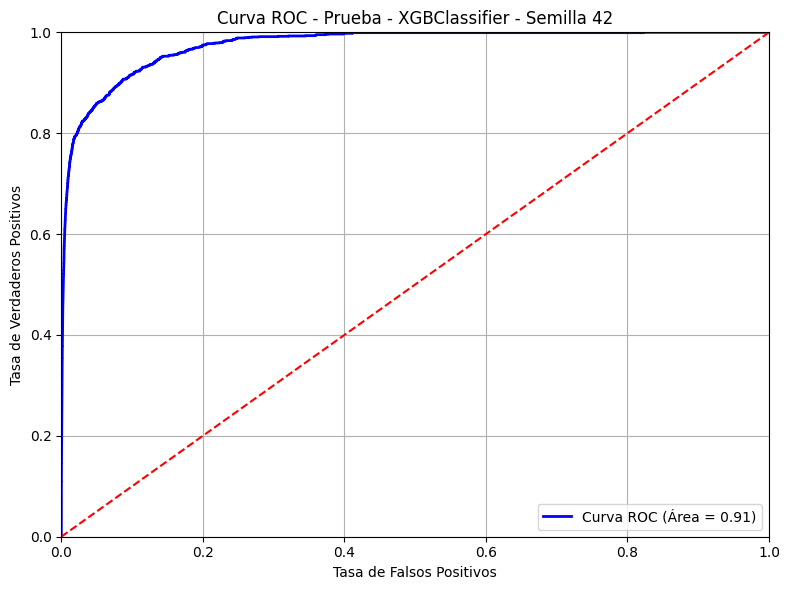

  XGBClassifier - undersampling (Semilla 42)
    Accuracy: 0.9154799776351051
    Precision: 0.05916929593292129
    Recall: 0.9006578947368421
    F1 Score: 0.11104351705398062
    ROC-AUC: 0.9081126294660492
    Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1}
Modelo guardado como model_XGBClassifier_undersampling_seed_42.pkl

--> Iniciando undersampling para CatBoostClassifier con semilla 42
Tamaño original de X_train: (778005, 4), y_train: (778005,)


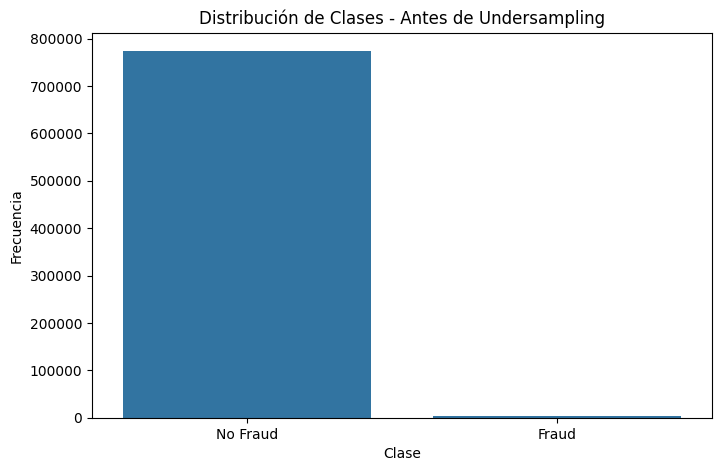

Tamaño después de undersampling de X_train: (8894, 4), y_train: (8894,)


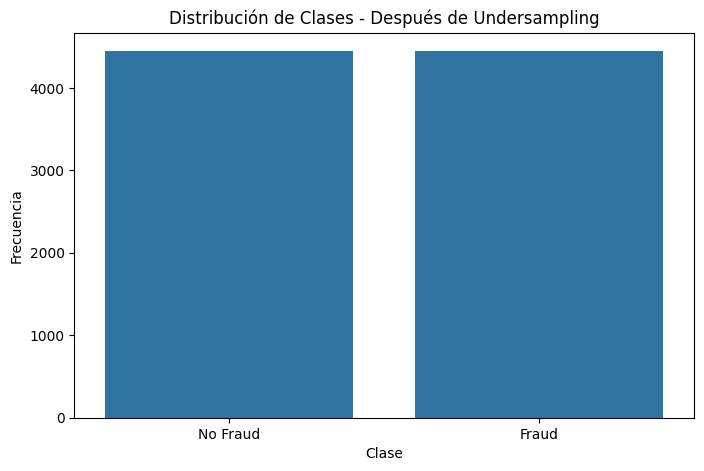


Evaluación en el conjunto de validación para CatBoostClassifier - Semilla 42
  CatBoostClassifier - undersampling (Semilla 42)
    Accuracy: 0.9116818015308384
    Precision: 0.057422214856858764
    Recall: 0.9005847953216374
    F1 Score: 0.1079607415485278
    ROC-AUC: 0.9061664220832302
    Best Parameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Modelo guardado como model_CatBoostClassifier_undersampling_seed_42.pkl


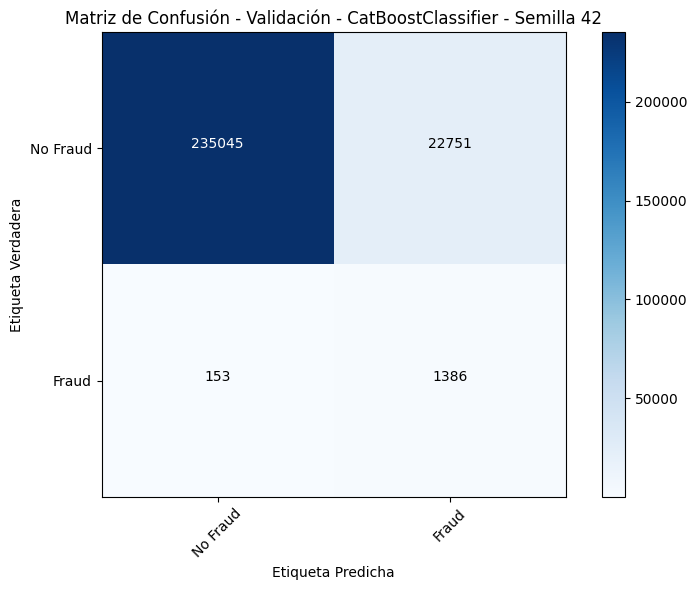

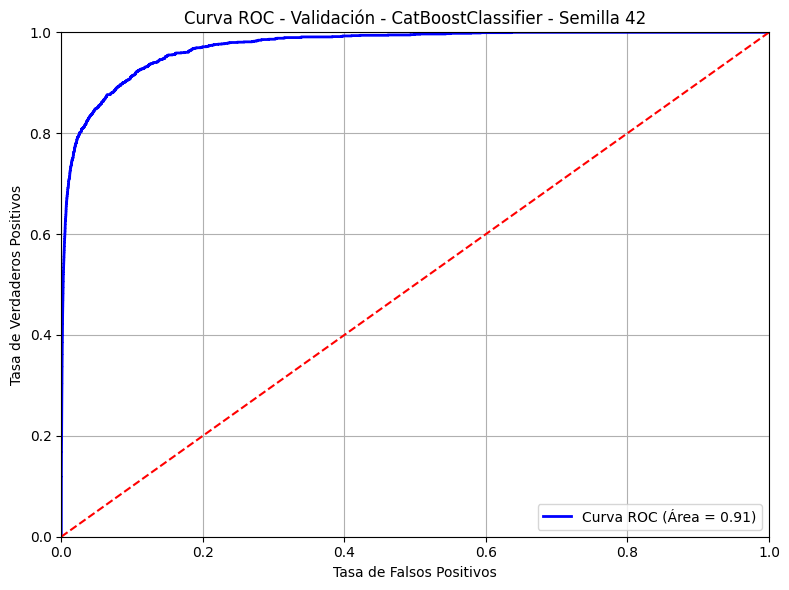


Evaluación final en el conjunto de prueba para CatBoostClassifier - Semilla 42
  CatBoostClassifier - undersampling (Semilla 42)
    Accuracy: 0.912337324310255
    Precision: 0.057229921522791785
    Recall: 0.9019736842105263
    F1 Score: 0.10763071125765426
    ROC-AUC: 0.9071860547189591
    Best Parameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Modelo guardado como model_CatBoostClassifier_undersampling_seed_42.pkl


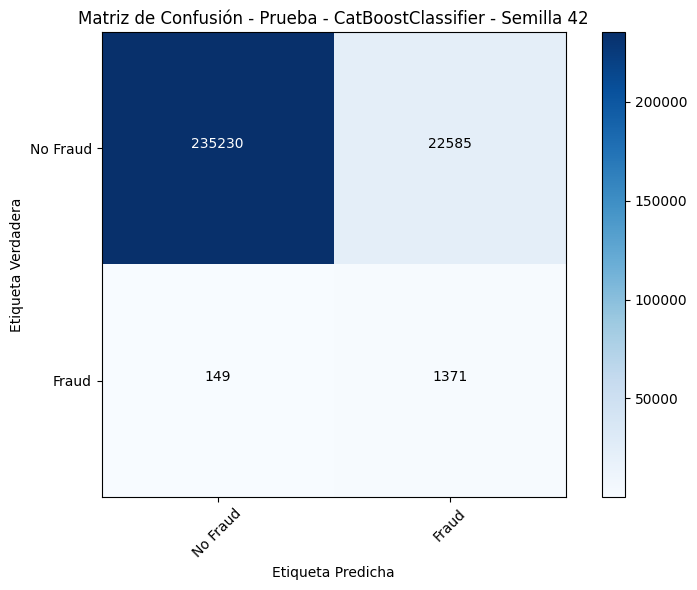

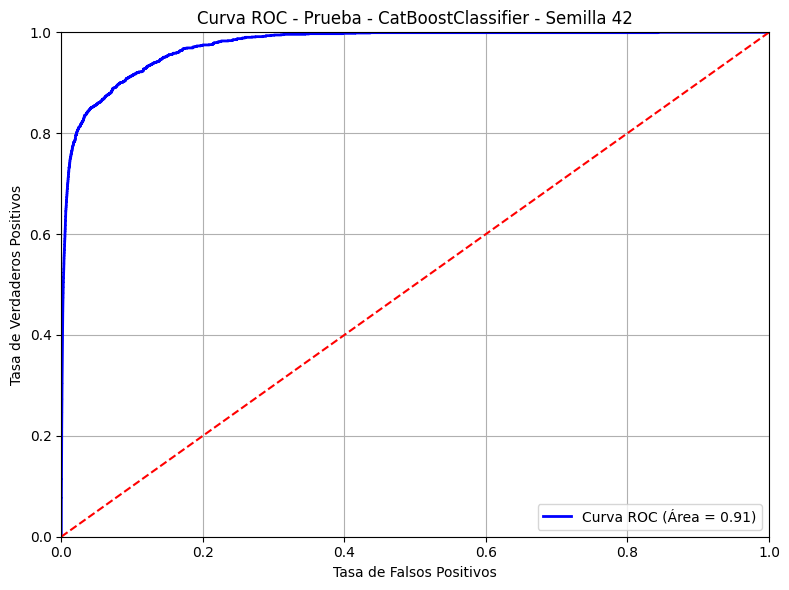

  CatBoostClassifier - undersampling (Semilla 42)
    Accuracy: 0.912337324310255
    Precision: 0.057229921522791785
    Recall: 0.9019736842105263
    F1 Score: 0.10763071125765426
    ROC-AUC: 0.9071860547189591
    Best Parameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Modelo guardado como model_CatBoostClassifier_undersampling_seed_42.pkl

--> Iniciando undersampling para LogisticRegression con semilla 15
Tamaño original de X_train: (778005, 4), y_train: (778005,)


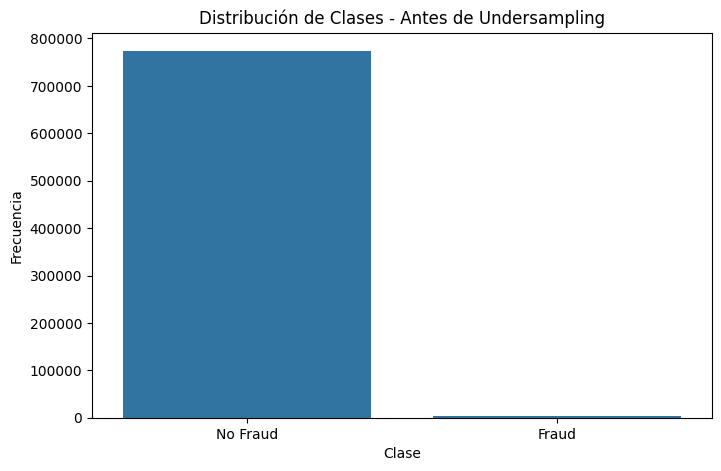

Tamaño después de undersampling de X_train: (9042, 4), y_train: (9042,)


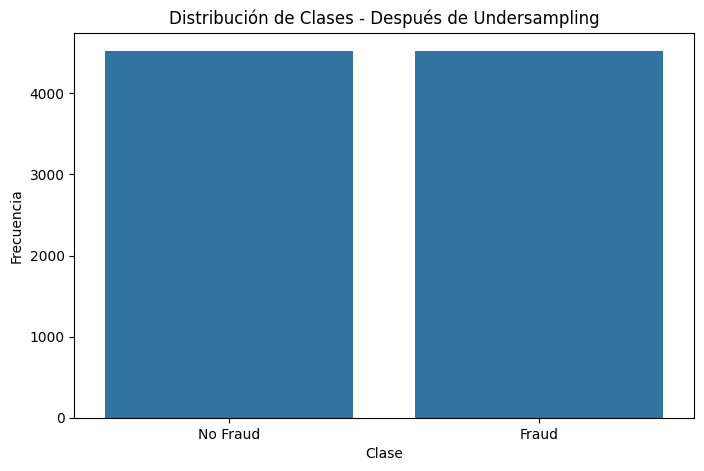


Evaluación en el conjunto de validación para LogisticRegression - Semilla 15
  LogisticRegression - undersampling (Semilla 15)
    Accuracy: 0.9585863844062699
    Precision: 0.09465343086032742
    Recall: 0.7601398601398601
    F1 Score: 0.1683444323989469
    ROC-AUC: 0.8599132832426098
    Best Parameters: {'C': 0.01}
Modelo guardado como model_LogisticRegression_undersampling_seed_15.pkl


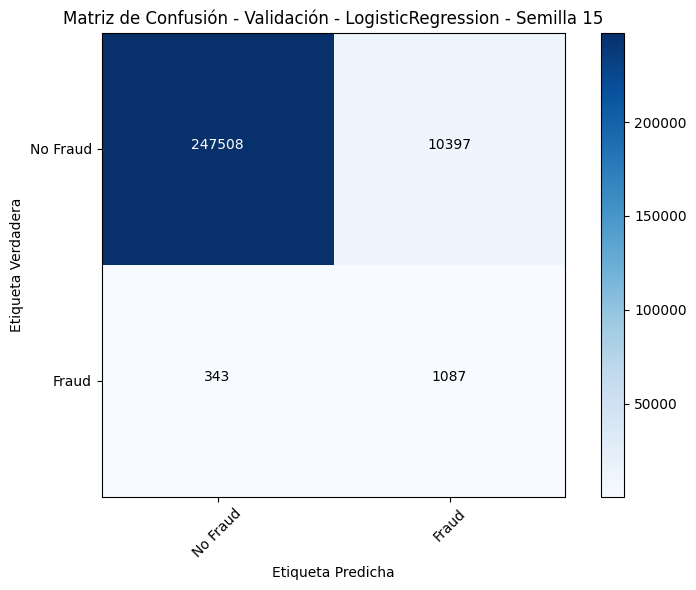

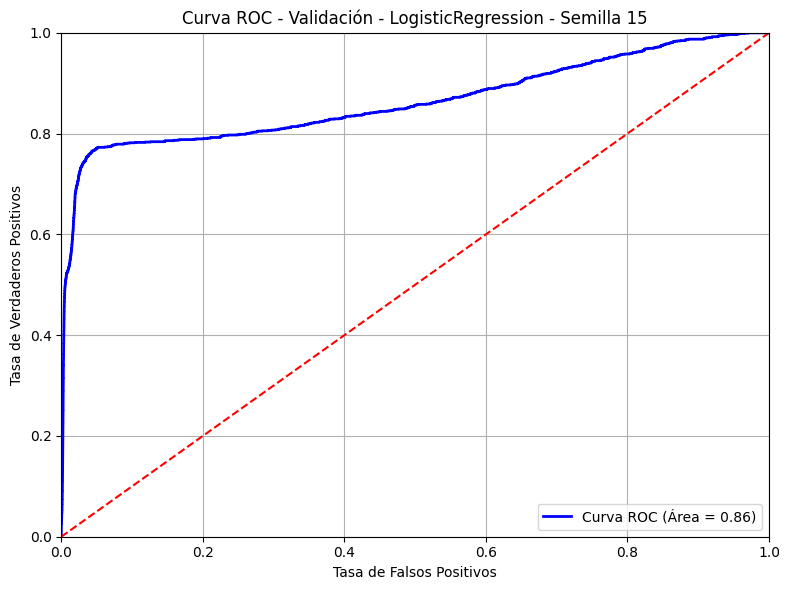


Evaluación final en el conjunto de prueba para LogisticRegression - Semilla 15
  LogisticRegression - undersampling (Semilla 15)
    Accuracy: 0.9574681396649122
    Precision: 0.1025920644241255
    Recall: 0.7864951768488746
    F1 Score: 0.1815078658355595
    ROC-AUC: 0.8724973362714386
    Best Parameters: {'C': 0.01}
Modelo guardado como model_LogisticRegression_undersampling_seed_15.pkl


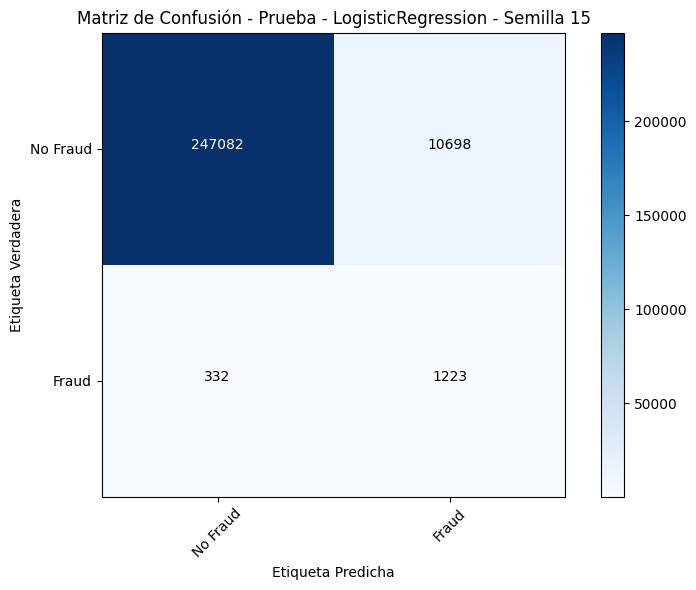

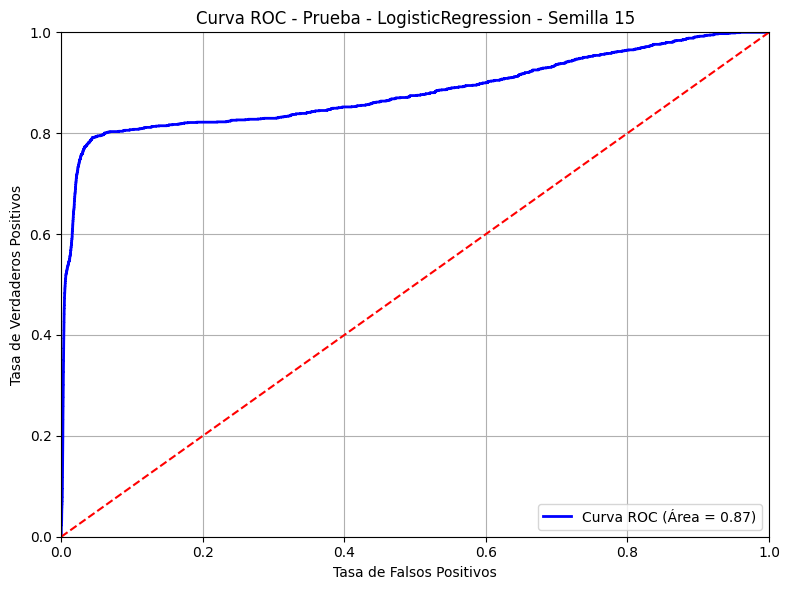

  LogisticRegression - undersampling (Semilla 15)
    Accuracy: 0.9574681396649122
    Precision: 0.1025920644241255
    Recall: 0.7864951768488746
    F1 Score: 0.1815078658355595
    ROC-AUC: 0.8724973362714386
    Best Parameters: {'C': 0.01}
Modelo guardado como model_LogisticRegression_undersampling_seed_15.pkl

--> Iniciando undersampling para DecisionTreeClassifier con semilla 15
Tamaño original de X_train: (778005, 4), y_train: (778005,)


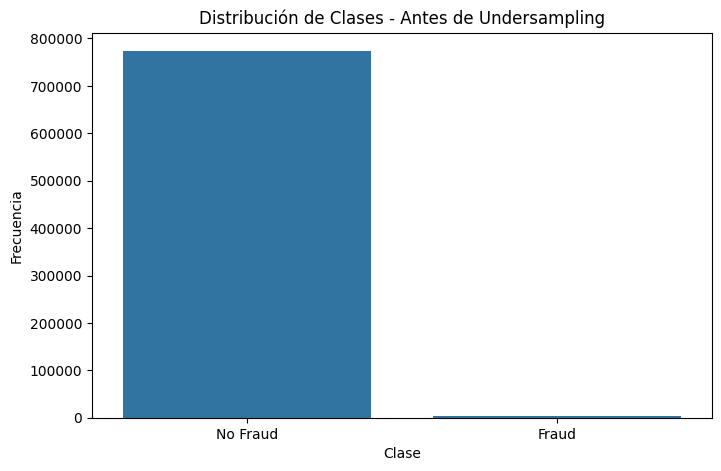

Tamaño después de undersampling de X_train: (9042, 4), y_train: (9042,)


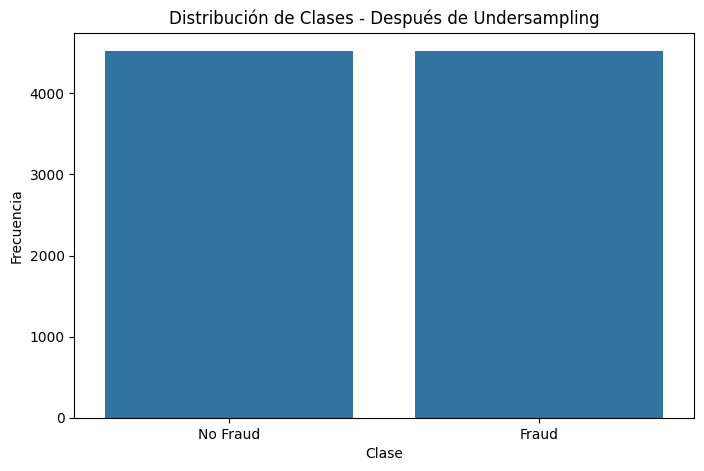


Evaluación en el conjunto de validación para DecisionTreeClassifier - Semilla 15
  DecisionTreeClassifier - undersampling (Semilla 15)
    Accuracy: 0.8941639192550176
    Precision: 0.04526864054252456
    Recall: 0.9055944055944056
    F1 Score: 0.08622698671638312
    ROC-AUC: 0.8998474732456239
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Modelo guardado como model_DecisionTreeClassifier_undersampling_seed_15.pkl


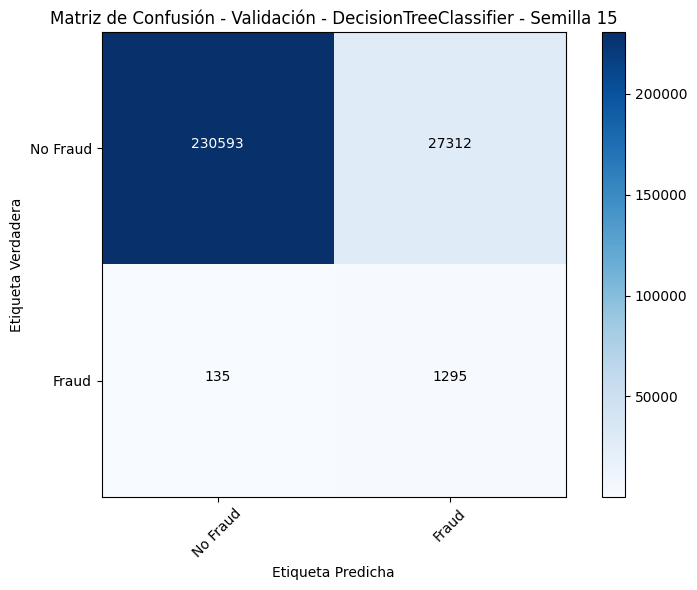

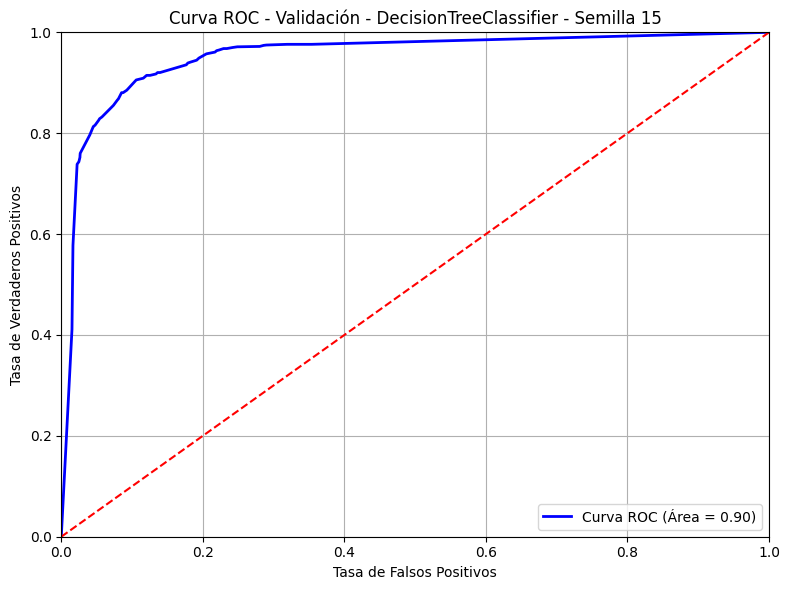


Evaluación final en el conjunto de prueba para DecisionTreeClassifier - Semilla 15
  DecisionTreeClassifier - undersampling (Semilla 15)
    Accuracy: 0.8939055661596005
    Precision: 0.049244660531342244
    Recall: 0.9118971061093247
    F1 Score: 0.09344316309719934
    ROC-AUC: 0.9028470711708855
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Modelo guardado como model_DecisionTreeClassifier_undersampling_seed_15.pkl


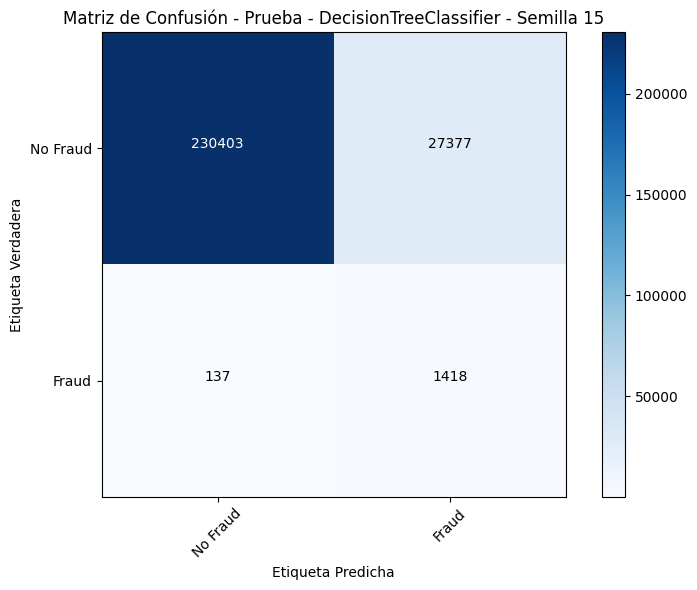

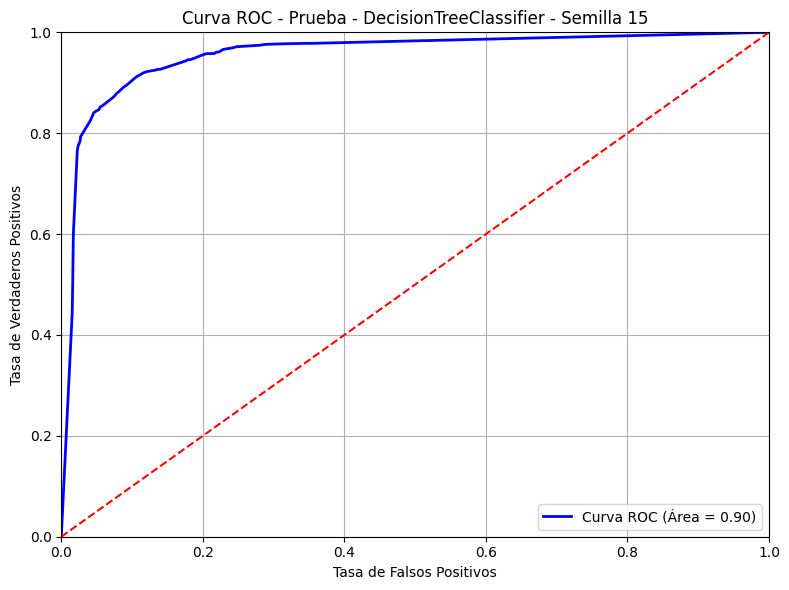

  DecisionTreeClassifier - undersampling (Semilla 15)
    Accuracy: 0.8939055661596005
    Precision: 0.049244660531342244
    Recall: 0.9118971061093247
    F1 Score: 0.09344316309719934
    ROC-AUC: 0.9028470711708855
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Modelo guardado como model_DecisionTreeClassifier_undersampling_seed_15.pkl

--> Iniciando undersampling para RandomForestClassifier con semilla 15
Tamaño original de X_train: (778005, 4), y_train: (778005,)


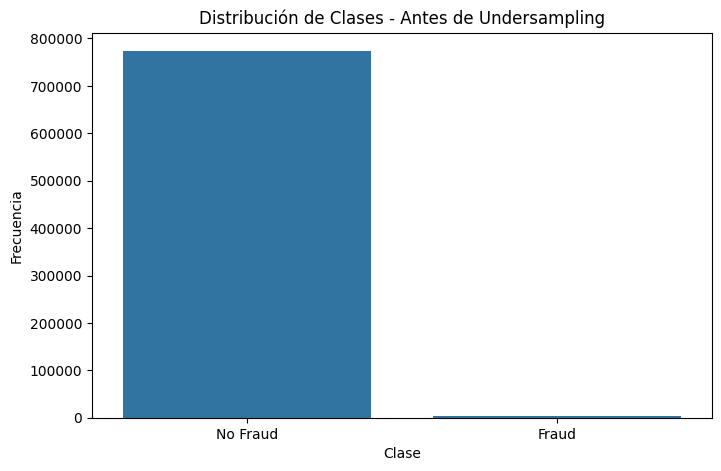

Tamaño después de undersampling de X_train: (9042, 4), y_train: (9042,)


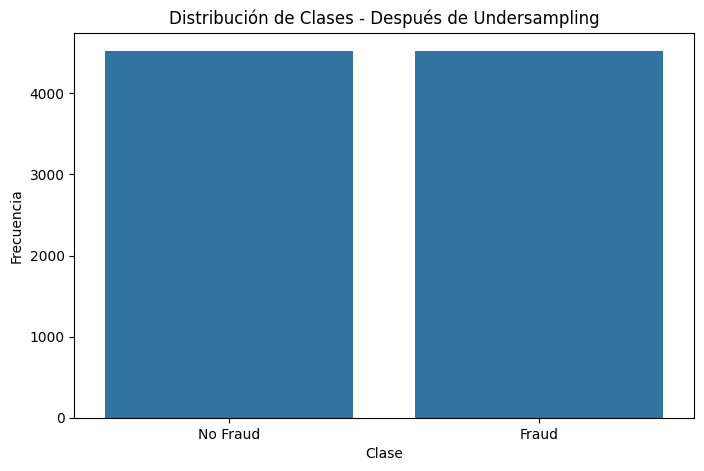


Evaluación en el conjunto de validación para RandomForestClassifier - Semilla 15
  RandomForestClassifier - undersampling (Semilla 15)
    Accuracy: 0.9229182331733087
    Precision: 0.05993930197268589
    Recall: 0.8839160839160839
    F1 Score: 0.1122657429611866
    ROC-AUC: 0.9035252857105865
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Modelo guardado como model_RandomForestClassifier_undersampling_seed_15.pkl


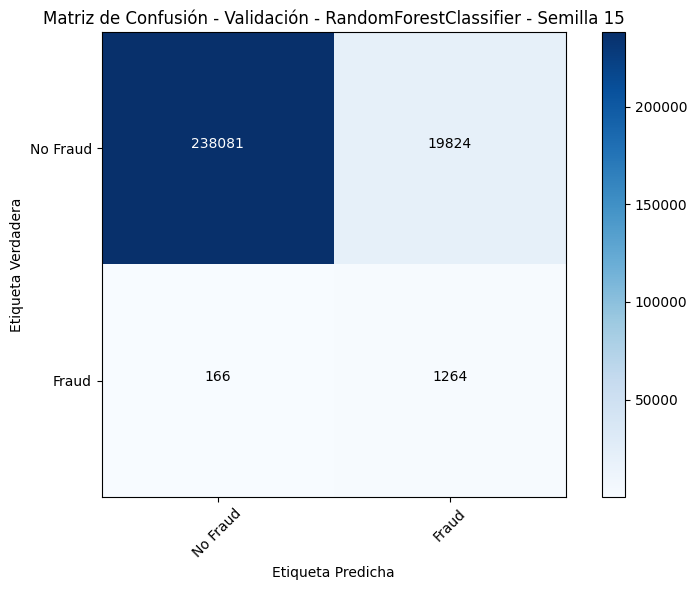

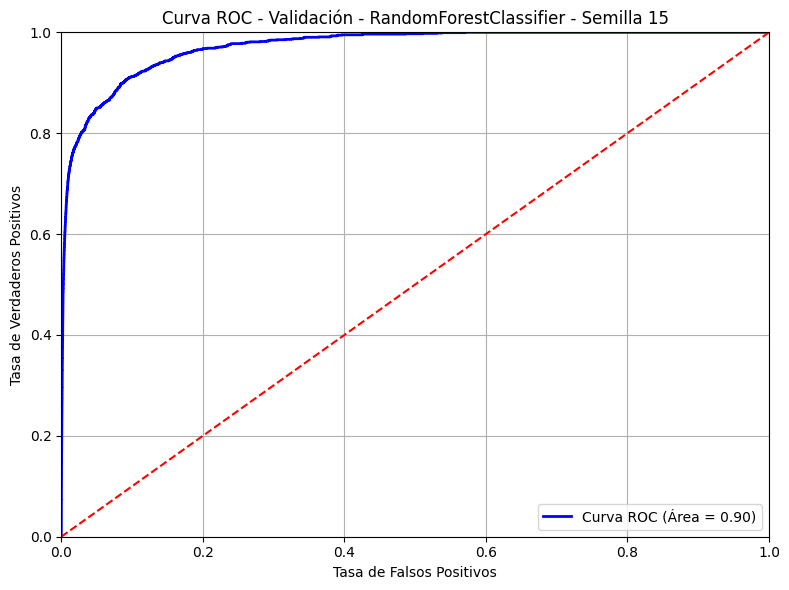


Evaluación final en el conjunto de prueba para RandomForestClassifier - Semilla 15
  RandomForestClassifier - undersampling (Semilla 15)
    Accuracy: 0.9229645053695028
    Precision: 0.06567966429346032
    Recall: 0.8958199356913183
    F1 Score: 0.12238622386223862
    ROC-AUC: 0.9094740922928622
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Modelo guardado como model_RandomForestClassifier_undersampling_seed_15.pkl


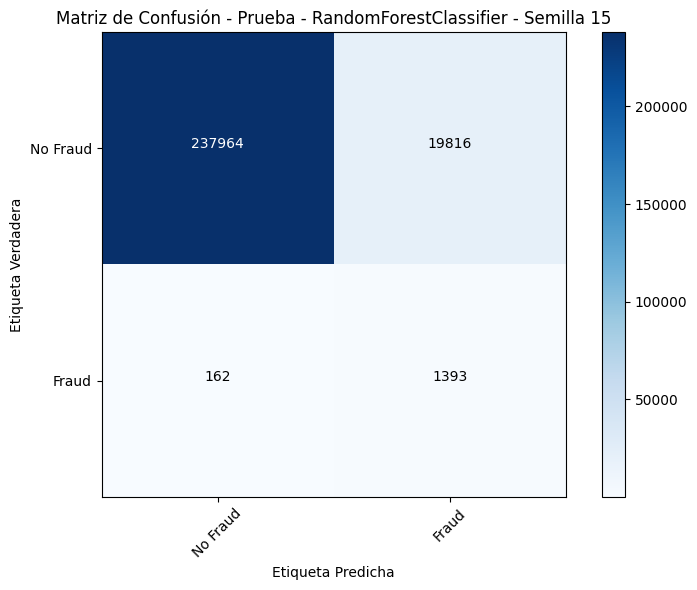

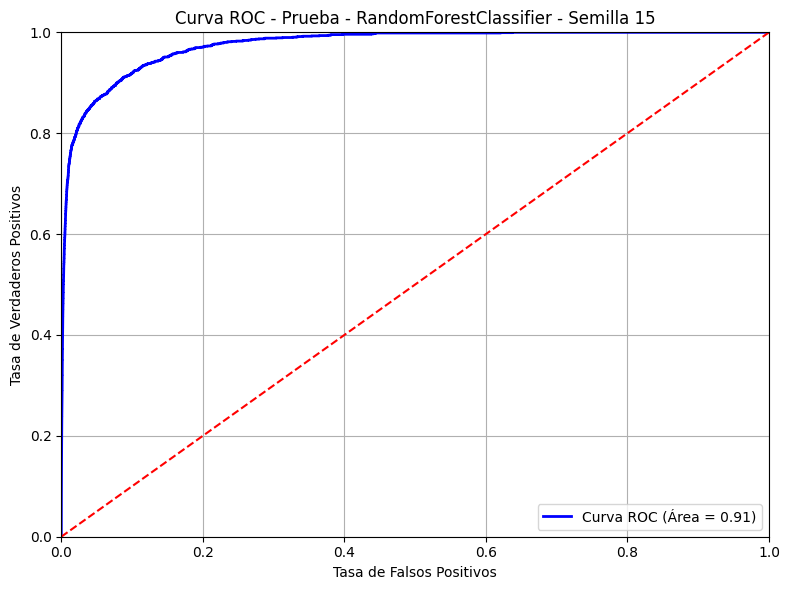

  RandomForestClassifier - undersampling (Semilla 15)
    Accuracy: 0.9229645053695028
    Precision: 0.06567966429346032
    Recall: 0.8958199356913183
    F1 Score: 0.12238622386223862
    ROC-AUC: 0.9094740922928622
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Modelo guardado como model_RandomForestClassifier_undersampling_seed_15.pkl

--> Iniciando undersampling para LGBMClassifier con semilla 15
Tamaño original de X_train: (778005, 4), y_train: (778005,)


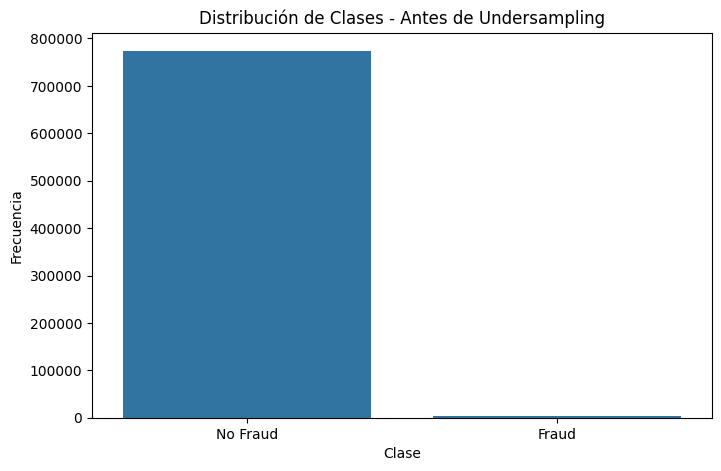

Tamaño después de undersampling de X_train: (9042, 4), y_train: (9042,)


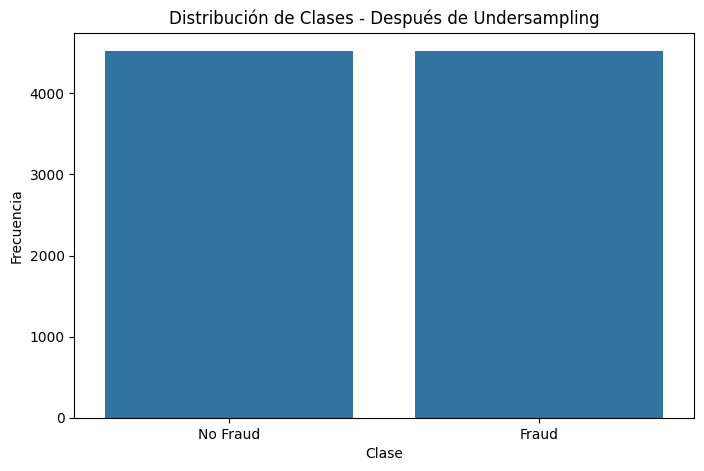

[LightGBM] [Info] Number of positive: 3617, number of negative: 3616
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 7233, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500069 -> initscore=0.000277
[LightGBM] [Info] Start training from score 0.000277
[LightGBM] [Info] Number of positive: 3616, number of negative: 3617
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 7233, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499931 -> initscore=-0.000277
[LightGBM] [Info] Start training from score -0.000277
[LightGBM] [Info] Numb

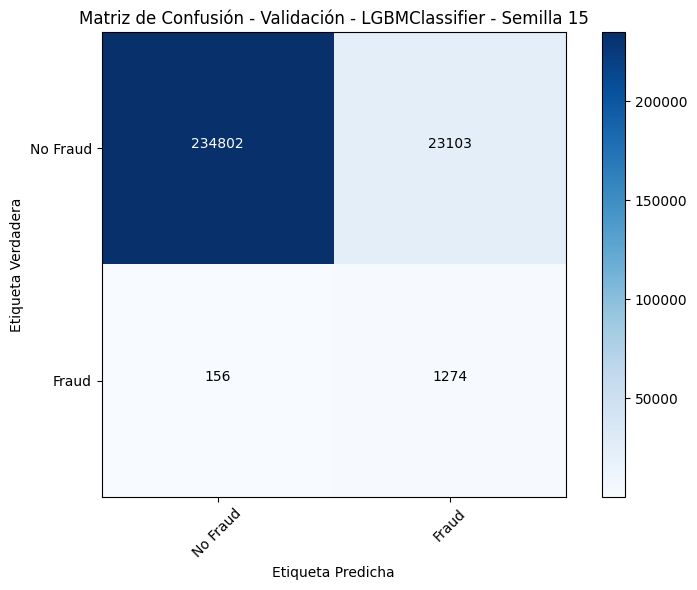

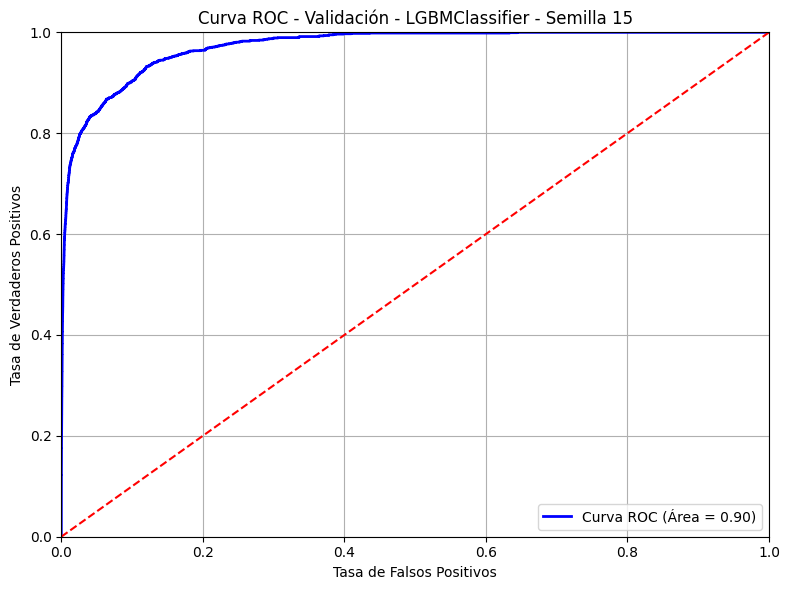


Evaluación final en el conjunto de prueba para LGBMClassifier - Semilla 15
  LGBMClassifier - undersampling (Semilla 15)
    Accuracy: 0.9109607264734803
    Precision: 0.058108995403808275
    Recall: 0.9106109324758842
    F1 Score: 0.10924661497511862
    ROC-AUC: 0.9107868845015777
    Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 50, 'scale_pos_weight': 1}
Modelo guardado como model_LGBMClassifier_undersampling_seed_15.pkl


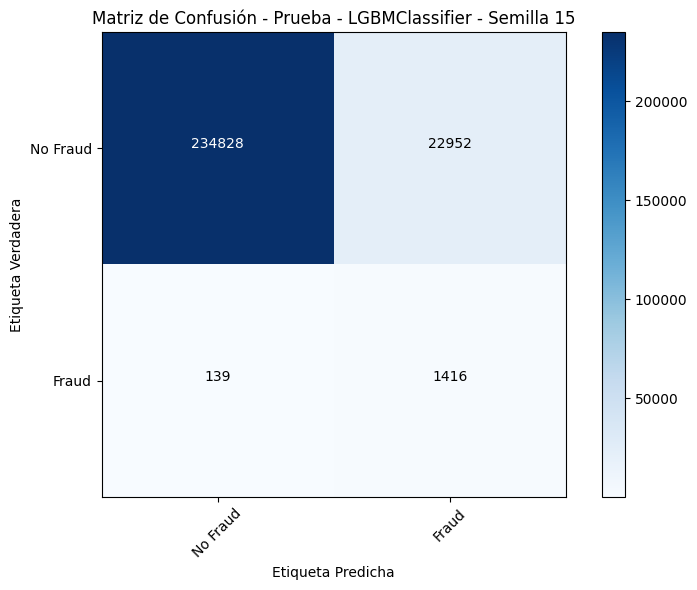

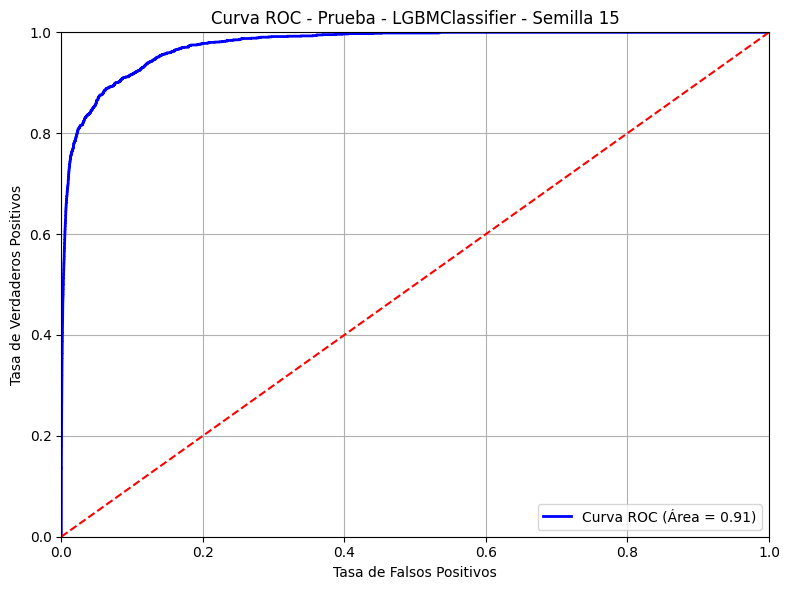

  LGBMClassifier - undersampling (Semilla 15)
    Accuracy: 0.9109607264734803
    Precision: 0.058108995403808275
    Recall: 0.9106109324758842
    F1 Score: 0.10924661497511862
    ROC-AUC: 0.9107868845015777
    Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 50, 'scale_pos_weight': 1}
Modelo guardado como model_LGBMClassifier_undersampling_seed_15.pkl

--> Iniciando undersampling para XGBClassifier con semilla 15
Tamaño original de X_train: (778005, 4), y_train: (778005,)


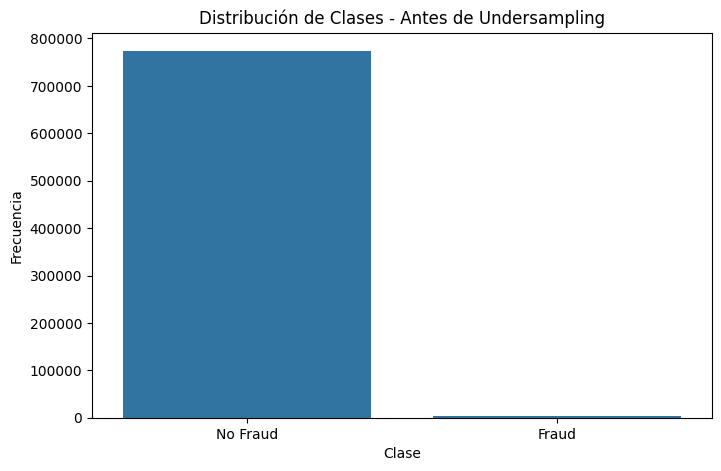

Tamaño después de undersampling de X_train: (9042, 4), y_train: (9042,)


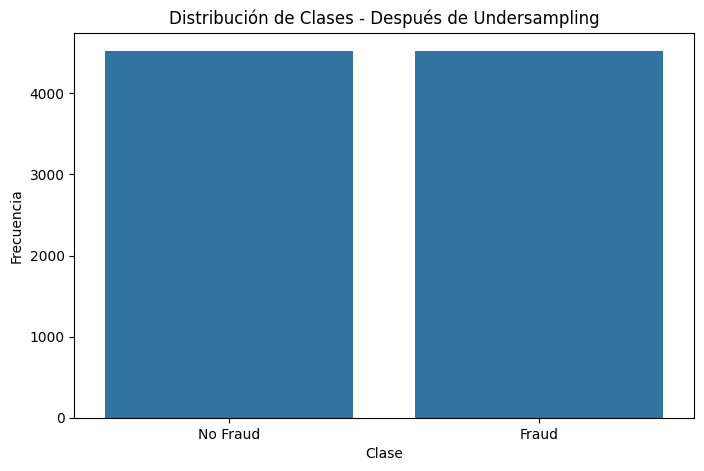


Evaluación en el conjunto de validación para XGBClassifier - Semilla 15
  XGBClassifier - undersampling (Semilla 15)
    Accuracy: 0.9206470395434476
    Precision: 0.05843287367984135
    Recall: 0.8860139860139861
    F1 Score: 0.10963527019426297
    ROC-AUC: 0.9034265273316475
    Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1}
Modelo guardado como model_XGBClassifier_undersampling_seed_15.pkl


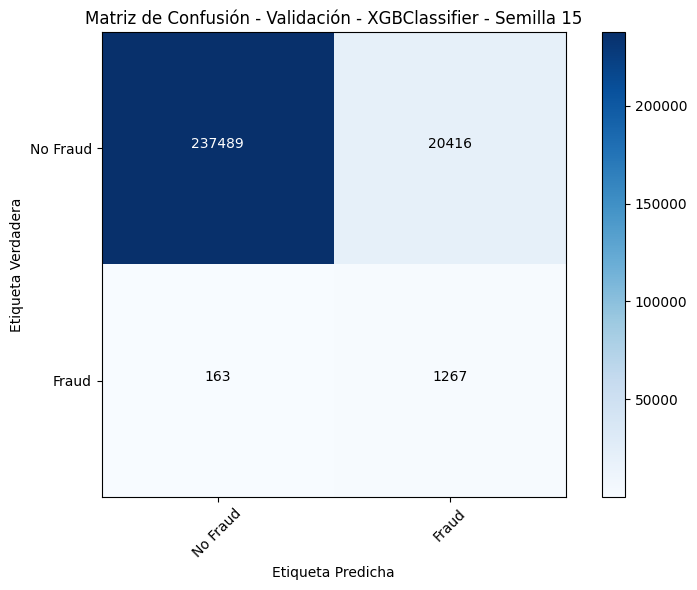

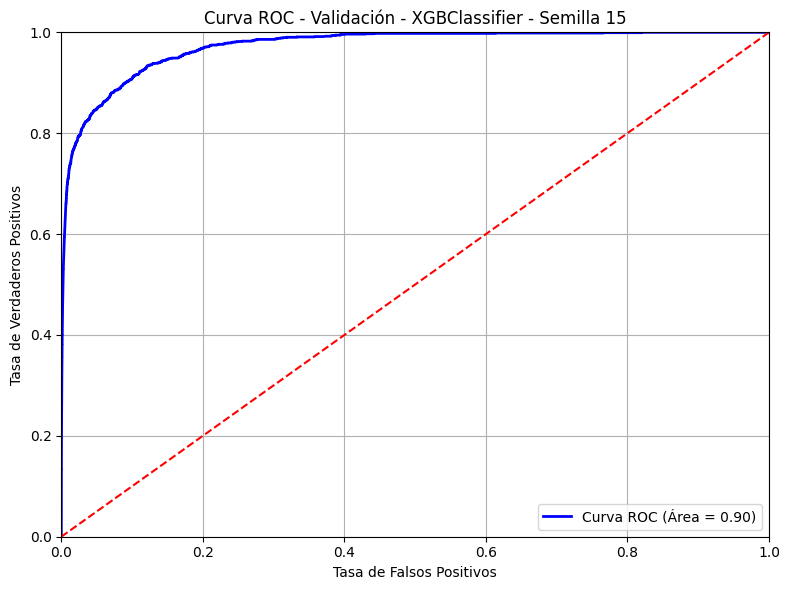


Evaluación final en el conjunto de prueba para XGBClassifier - Semilla 15
  XGBClassifier - undersampling (Semilla 15)
    Accuracy: 0.9206084793799526
    Precision: 0.06423992673992673
    Recall: 0.9022508038585209
    F1 Score: 0.11994015815345159
    ROC-AUC: 0.9114850108981487
    Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1}
Modelo guardado como model_XGBClassifier_undersampling_seed_15.pkl


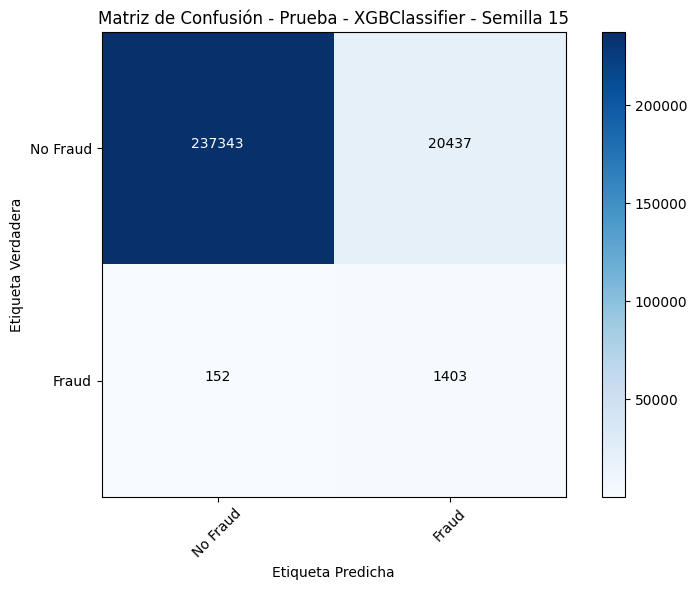

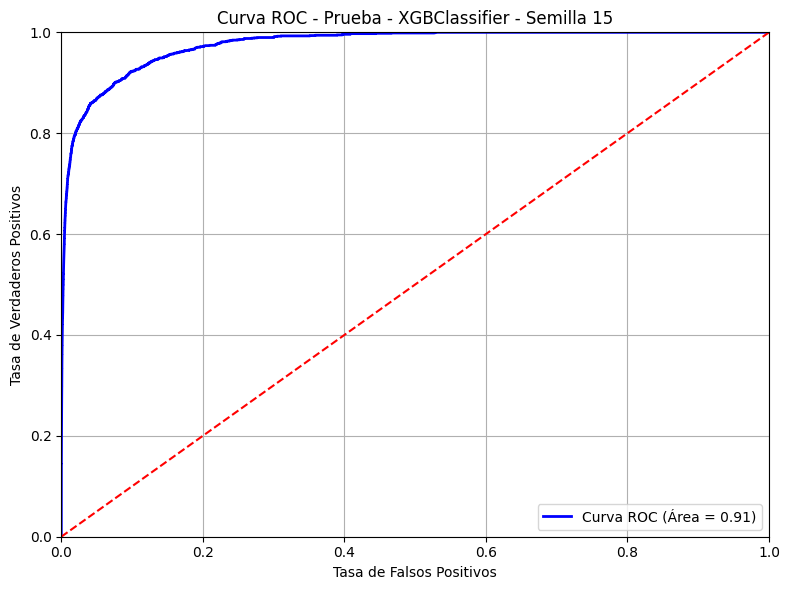

  XGBClassifier - undersampling (Semilla 15)
    Accuracy: 0.9206084793799526
    Precision: 0.06423992673992673
    Recall: 0.9022508038585209
    F1 Score: 0.11994015815345159
    ROC-AUC: 0.9114850108981487
    Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1}
Modelo guardado como model_XGBClassifier_undersampling_seed_15.pkl

--> Iniciando undersampling para CatBoostClassifier con semilla 15
Tamaño original de X_train: (778005, 4), y_train: (778005,)


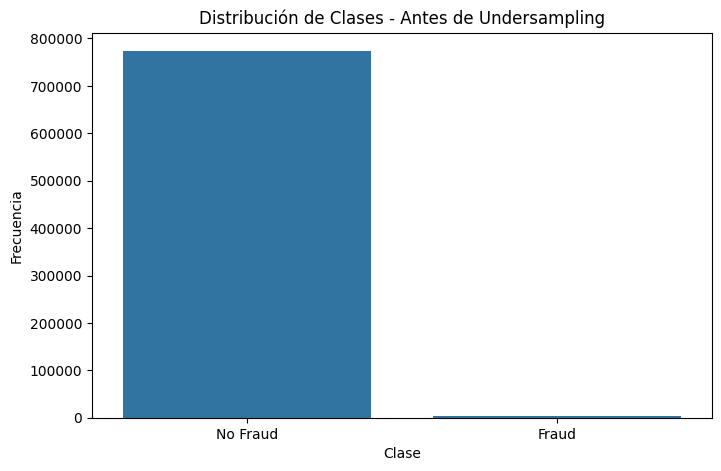

Tamaño después de undersampling de X_train: (9042, 4), y_train: (9042,)


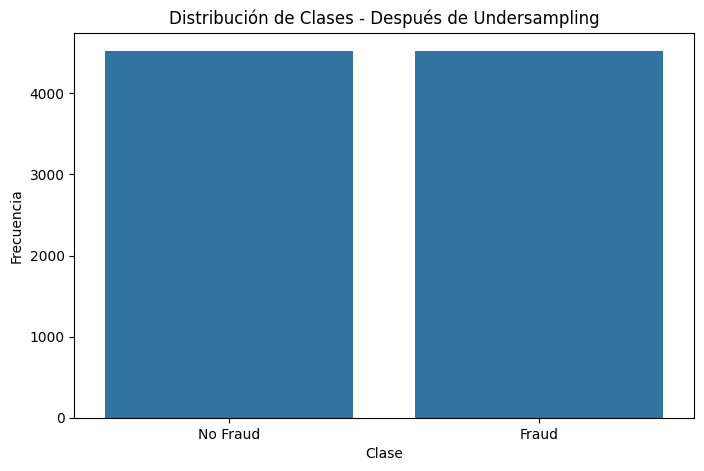


Evaluación en el conjunto de validación para CatBoostClassifier - Semilla 15
  CatBoostClassifier - undersampling (Semilla 15)
    Accuracy: 0.9194940906549444
    Precision: 0.057919621749408984
    Recall: 0.8909090909090909
    F1 Score: 0.10876803551609324
    ROC-AUC: 0.9052808380816756
    Best Parameters: {'depth': 4, 'iterations': 200, 'learning_rate': 0.1}
Modelo guardado como model_CatBoostClassifier_undersampling_seed_15.pkl


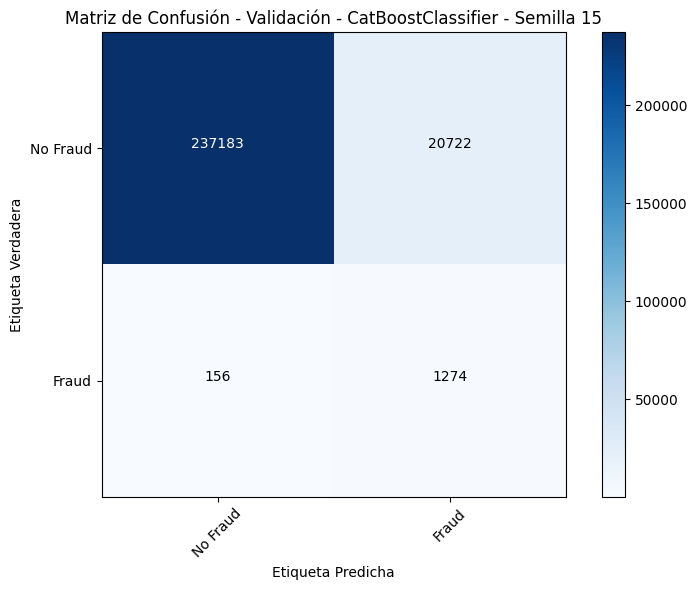

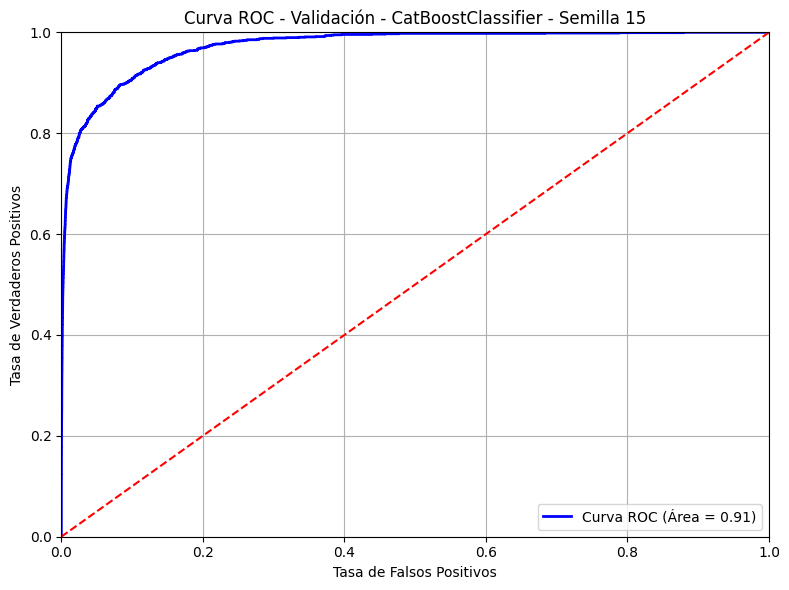


Evaluación final en el conjunto de prueba para CatBoostClassifier - Semilla 15
  CatBoostClassifier - undersampling (Semilla 15)
    Accuracy: 0.9196444752925752
    Precision: 0.06355241716458447
    Recall: 0.9028938906752412
    F1 Score: 0.11874656404617923
    ROC-AUC: 0.9113197050552093
    Best Parameters: {'depth': 4, 'iterations': 200, 'learning_rate': 0.1}
Modelo guardado como model_CatBoostClassifier_undersampling_seed_15.pkl


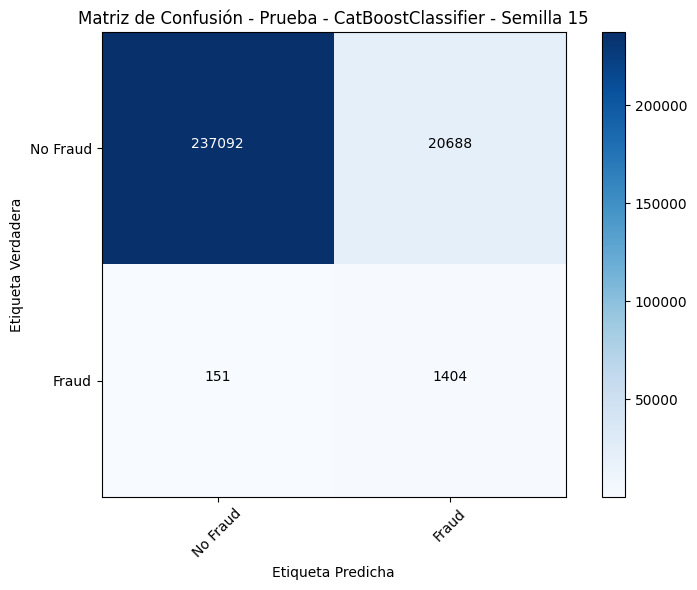

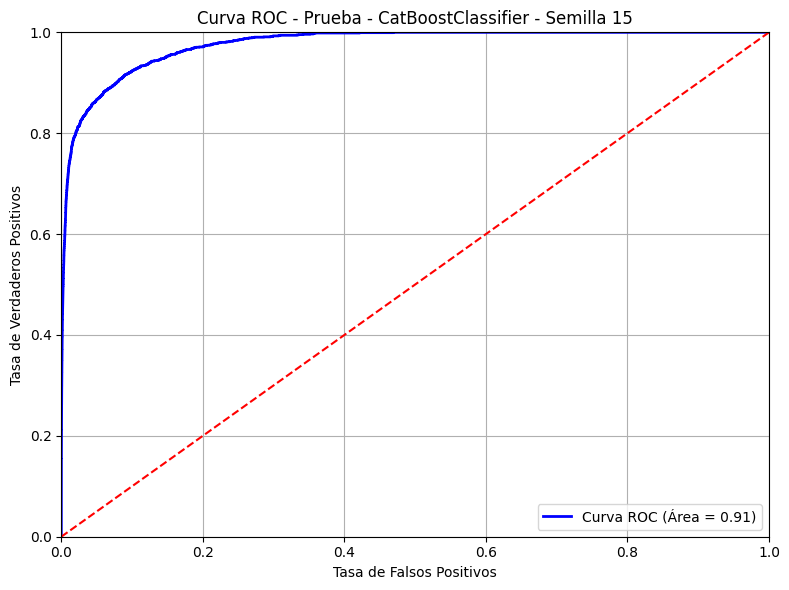

  CatBoostClassifier - undersampling (Semilla 15)
    Accuracy: 0.9196444752925752
    Precision: 0.06355241716458447
    Recall: 0.9028938906752412
    F1 Score: 0.11874656404617923
    ROC-AUC: 0.9113197050552093
    Best Parameters: {'depth': 4, 'iterations': 200, 'learning_rate': 0.1}
Modelo guardado como model_CatBoostClassifier_undersampling_seed_15.pkl

--> Iniciando undersampling para LogisticRegression con semilla 1235
Tamaño original de X_train: (778005, 4), y_train: (778005,)


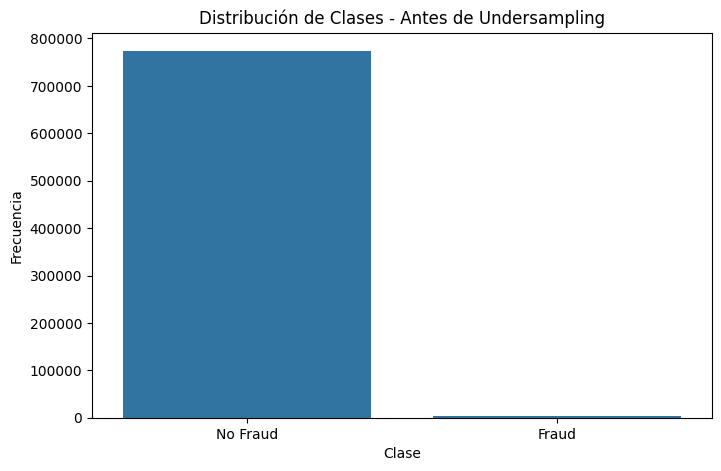

Tamaño después de undersampling de X_train: (9002, 4), y_train: (9002,)


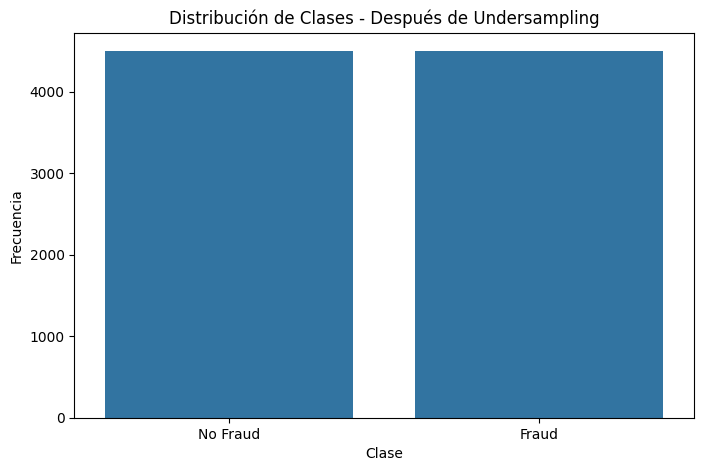


Evaluación en el conjunto de validación para LogisticRegression - Semilla 1235
  LogisticRegression - undersampling (Semilla 1235)
    Accuracy: 0.9484142132762643
    Precision: 0.08266554196541544
    Recall: 0.7819148936170213
    F1 Score: 0.14952320406865863
    ROC-AUC: 0.8656501718881171
    Best Parameters: {'C': 0.1}
Modelo guardado como model_LogisticRegression_undersampling_seed_1235.pkl


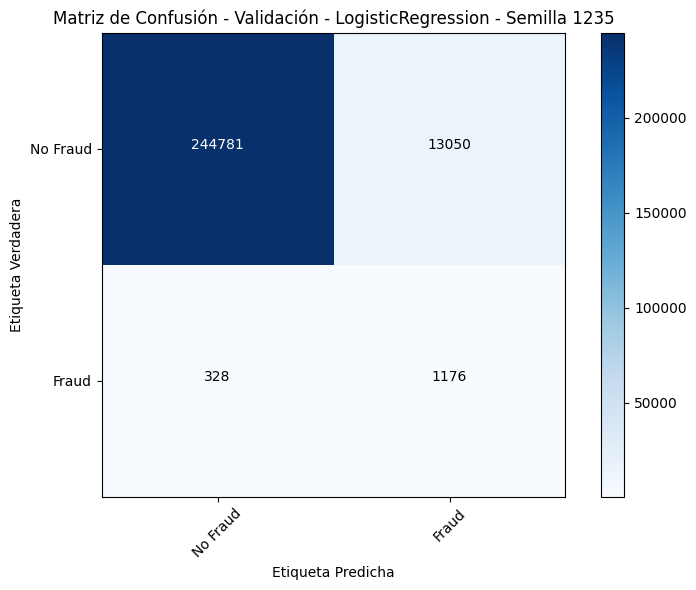

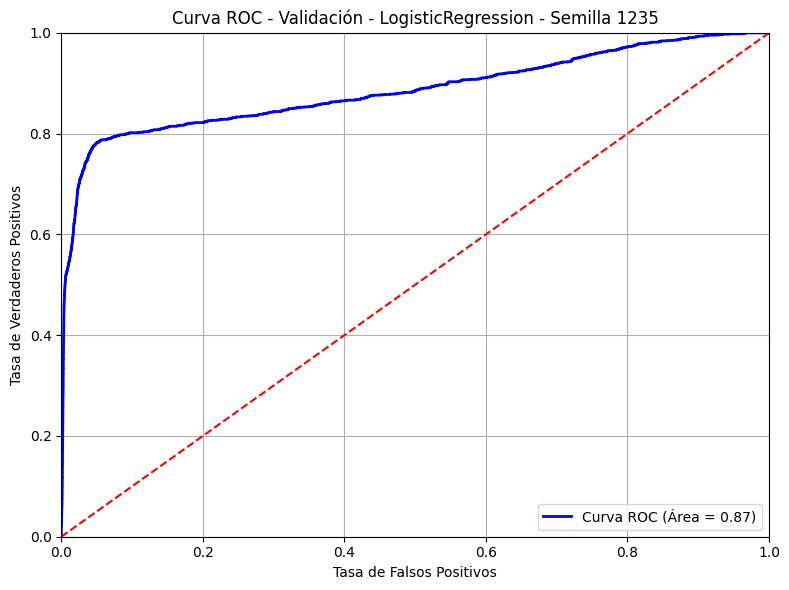


Evaluación final en el conjunto de prueba para LogisticRegression - Semilla 1235
  LogisticRegression - undersampling (Semilla 1235)
    Accuracy: 0.94868413442073
    Precision: 0.08163843809793778
    Recall: 0.7674883411059293
    F1 Score: 0.14757878554957723
    ROC-AUC: 0.8586136602246139
    Best Parameters: {'C': 0.1}
Modelo guardado como model_LogisticRegression_undersampling_seed_1235.pkl


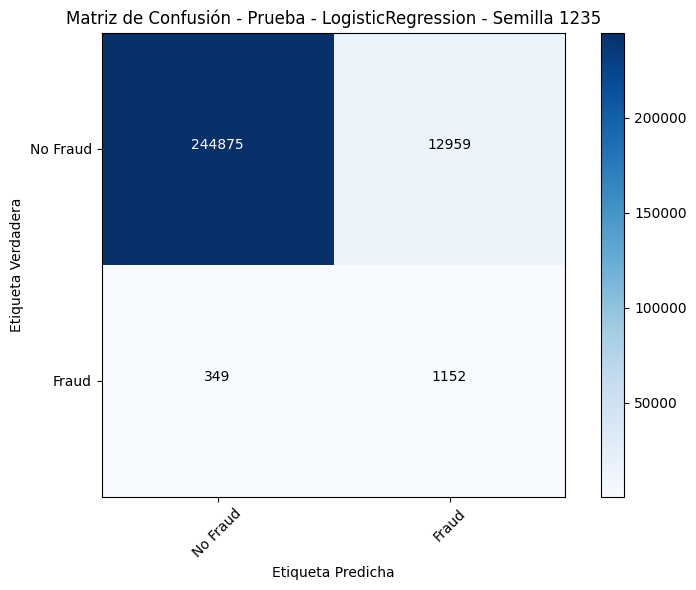

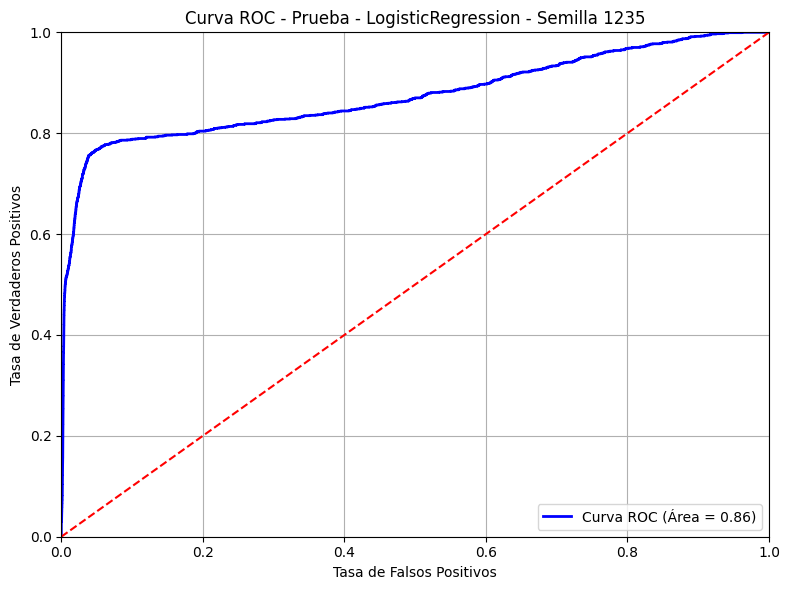

  LogisticRegression - undersampling (Semilla 1235)
    Accuracy: 0.94868413442073
    Precision: 0.08163843809793778
    Recall: 0.7674883411059293
    F1 Score: 0.14757878554957723
    ROC-AUC: 0.8586136602246139
    Best Parameters: {'C': 0.1}
Modelo guardado como model_LogisticRegression_undersampling_seed_1235.pkl

--> Iniciando undersampling para DecisionTreeClassifier con semilla 1235
Tamaño original de X_train: (778005, 4), y_train: (778005,)


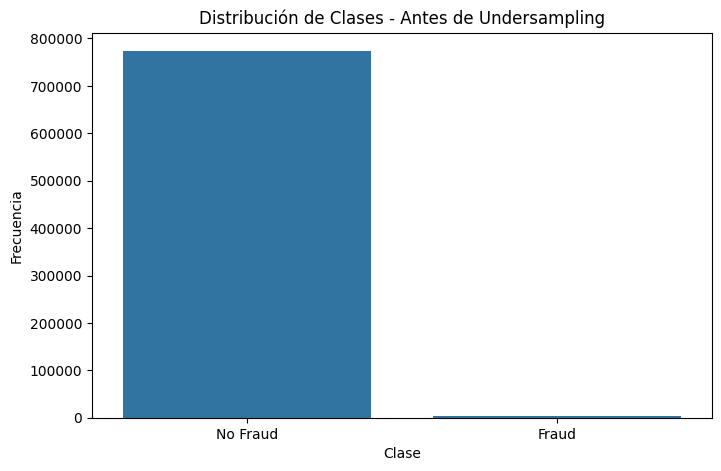

Tamaño después de undersampling de X_train: (9002, 4), y_train: (9002,)


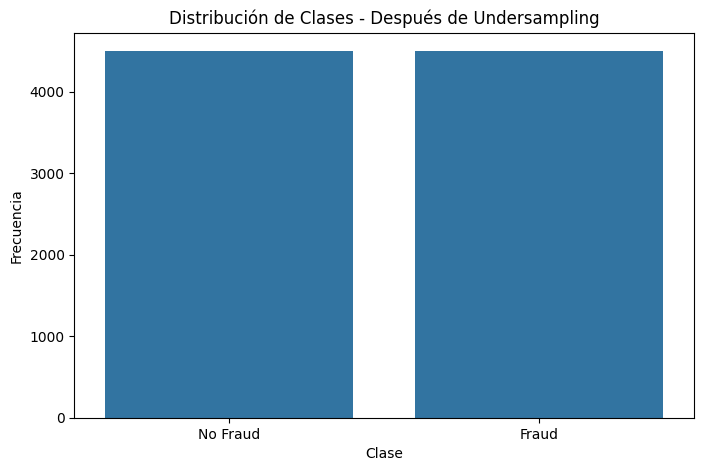


Evaluación en el conjunto de validación para DecisionTreeClassifier - Semilla 1235
  DecisionTreeClassifier - undersampling (Semilla 1235)
    Accuracy: 0.9093373435903368
    Precision: 0.05366269165247019
    Recall: 0.879654255319149
    F1 Score: 0.101154522517012
    ROC-AUC: 0.8945823743133904
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Modelo guardado como model_DecisionTreeClassifier_undersampling_seed_1235.pkl


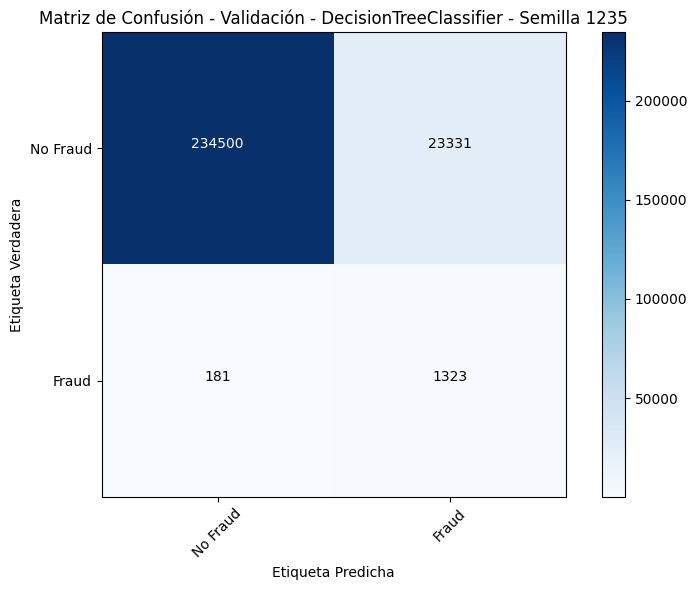

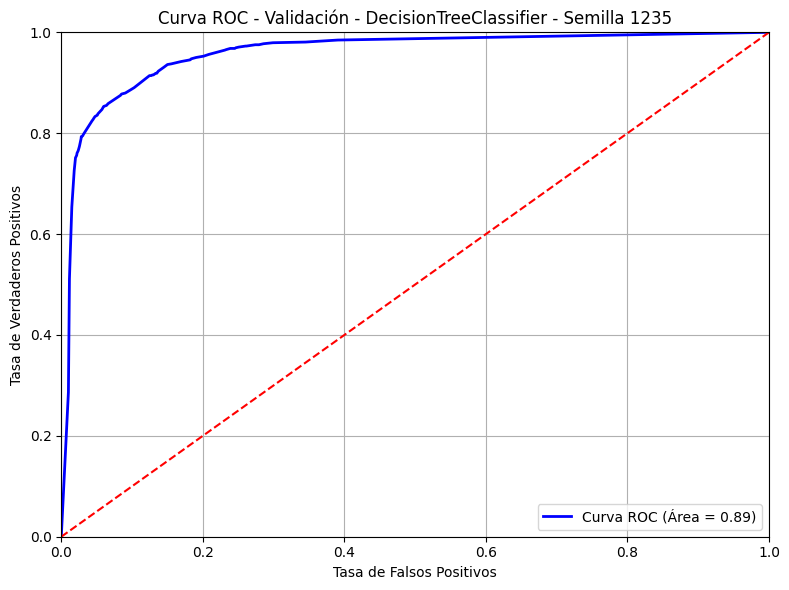


Evaluación final en el conjunto de prueba para DecisionTreeClassifier - Semilla 1235
  DecisionTreeClassifier - undersampling (Semilla 1235)
    Accuracy: 0.9081959627508821
    Precision: 0.05237388128586908
    Recall: 0.8694203864090606
    F1 Score: 0.0987962752668635
    ROC-AUC: 0.8889210420452573
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Modelo guardado como model_DecisionTreeClassifier_undersampling_seed_1235.pkl


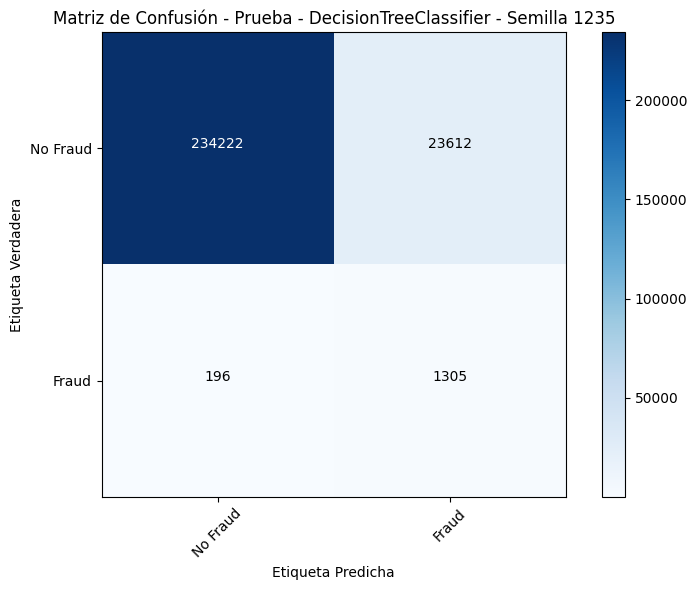

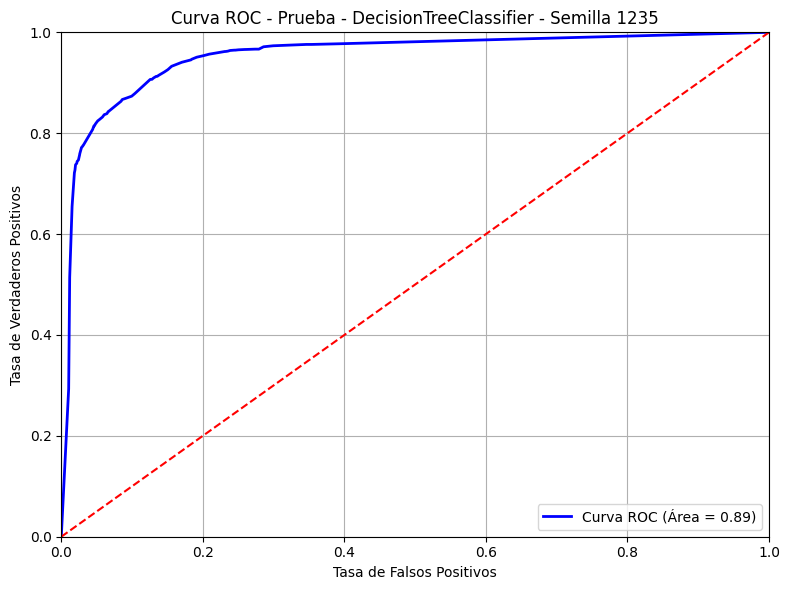

  DecisionTreeClassifier - undersampling (Semilla 1235)
    Accuracy: 0.9081959627508821
    Precision: 0.05237388128586908
    Recall: 0.8694203864090606
    F1 Score: 0.0987962752668635
    ROC-AUC: 0.8889210420452573
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Modelo guardado como model_DecisionTreeClassifier_undersampling_seed_1235.pkl

--> Iniciando undersampling para RandomForestClassifier con semilla 1235
Tamaño original de X_train: (778005, 4), y_train: (778005,)


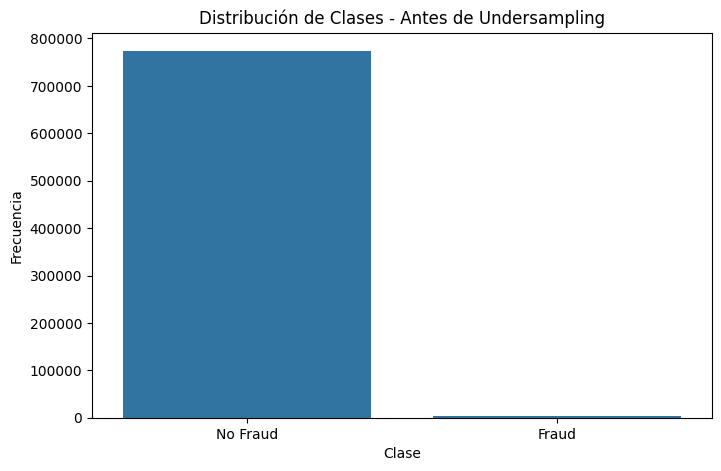

Tamaño después de undersampling de X_train: (9002, 4), y_train: (9002,)


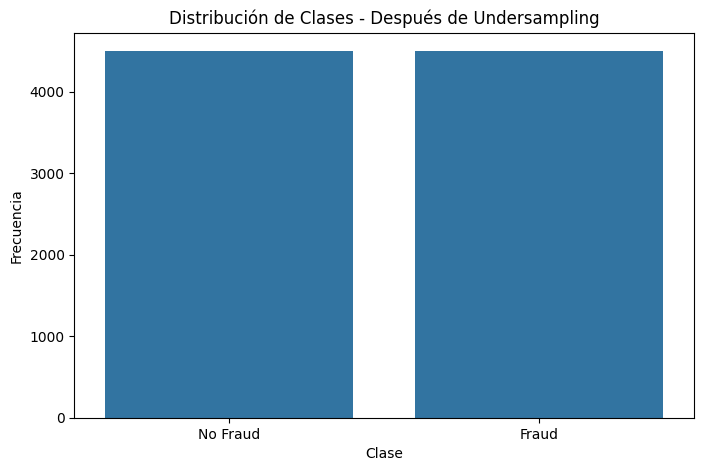


Evaluación en el conjunto de validación para RandomForestClassifier - Semilla 1235
  RandomForestClassifier - undersampling (Semilla 1235)
    Accuracy: 0.9305955617251818
    Precision: 0.06947851960119017
    Recall: 0.8849734042553191
    F1 Score: 0.1288417791975219
    ROC-AUC: 0.9079175463628368
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Modelo guardado como model_RandomForestClassifier_undersampling_seed_1235.pkl


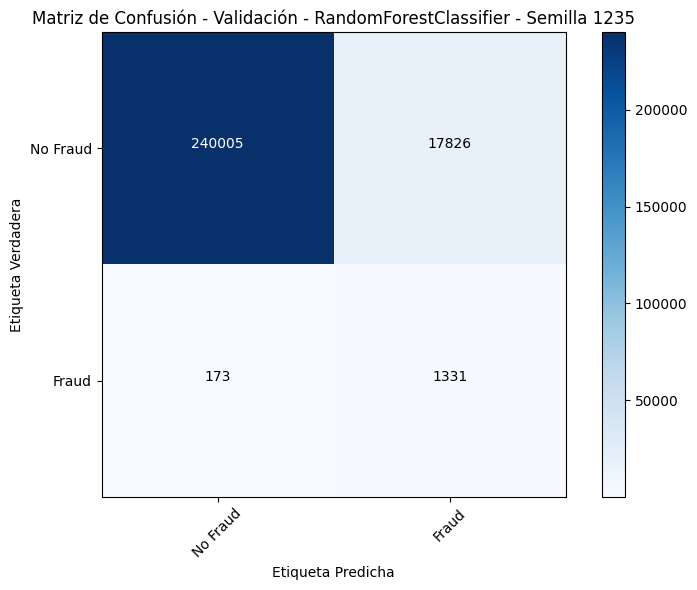

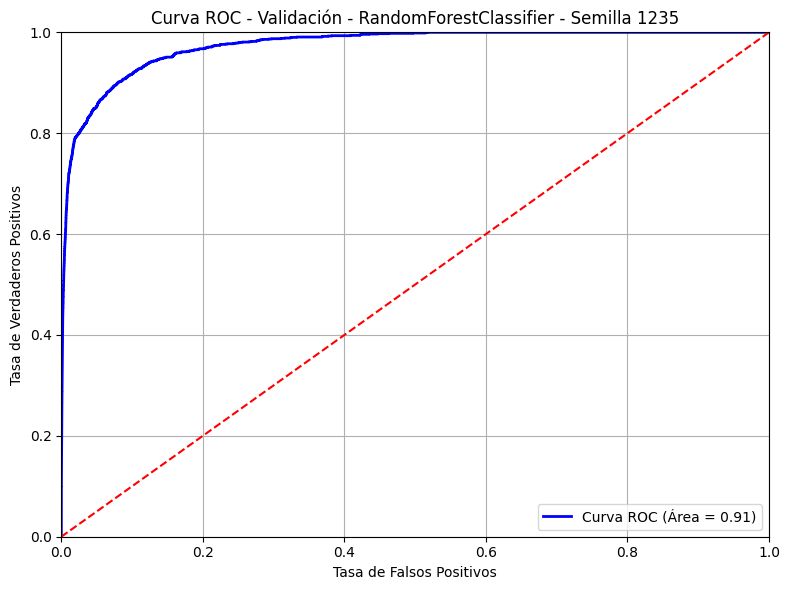


Evaluación final en el conjunto de prueba para RandomForestClassifier - Semilla 1235
  RandomForestClassifier - undersampling (Semilla 1235)
    Accuracy: 0.930726666281065
    Precision: 0.06837248322147652
    Recall: 0.8687541638907396
    F1 Score: 0.12676809410392262
    ROC-AUC: 0.8999208038749835
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Modelo guardado como model_RandomForestClassifier_undersampling_seed_1235.pkl


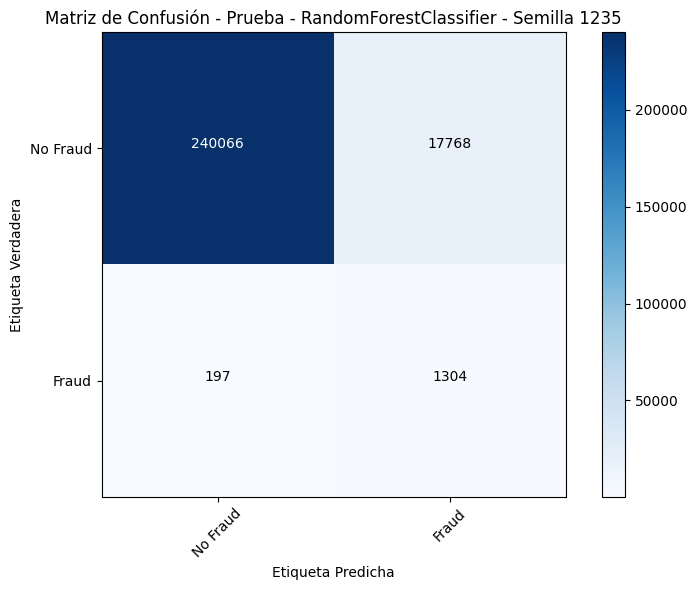

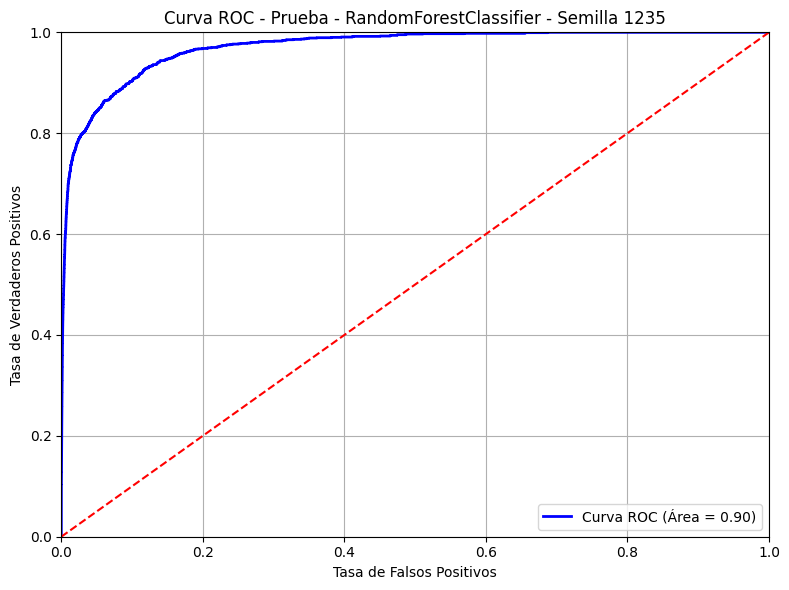

  RandomForestClassifier - undersampling (Semilla 1235)
    Accuracy: 0.930726666281065
    Precision: 0.06837248322147652
    Recall: 0.8687541638907396
    F1 Score: 0.12676809410392262
    ROC-AUC: 0.8999208038749835
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Modelo guardado como model_RandomForestClassifier_undersampling_seed_1235.pkl

--> Iniciando undersampling para LGBMClassifier con semilla 1235
Tamaño original de X_train: (778005, 4), y_train: (778005,)


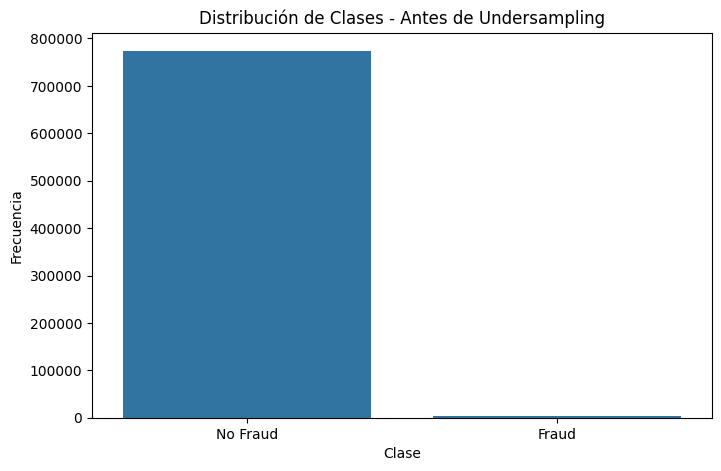

Tamaño después de undersampling de X_train: (9002, 4), y_train: (9002,)


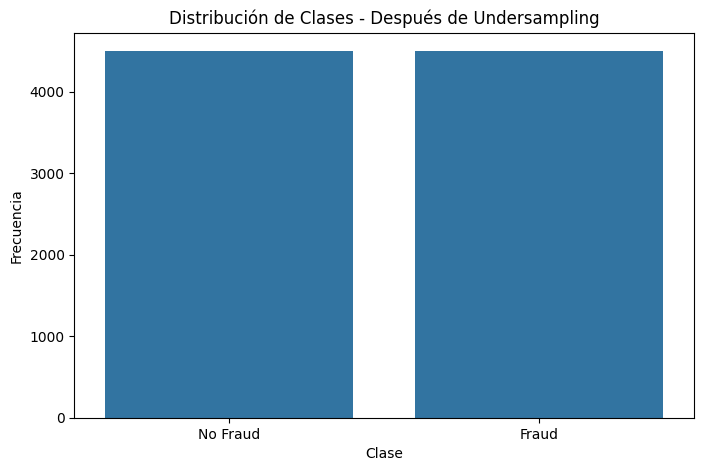

[LightGBM] [Info] Number of positive: 3601, number of negative: 3600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 7201, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500069 -> initscore=0.000278
[LightGBM] [Info] Start training from score 0.000278
[LightGBM] [Info] Number of positive: 3600, number of negative: 3601
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 7201, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499931 -> initscore=-0.000278
[LightGBM] [Info] Start training from score -0.000278
[LightGBM] [Info] Numb

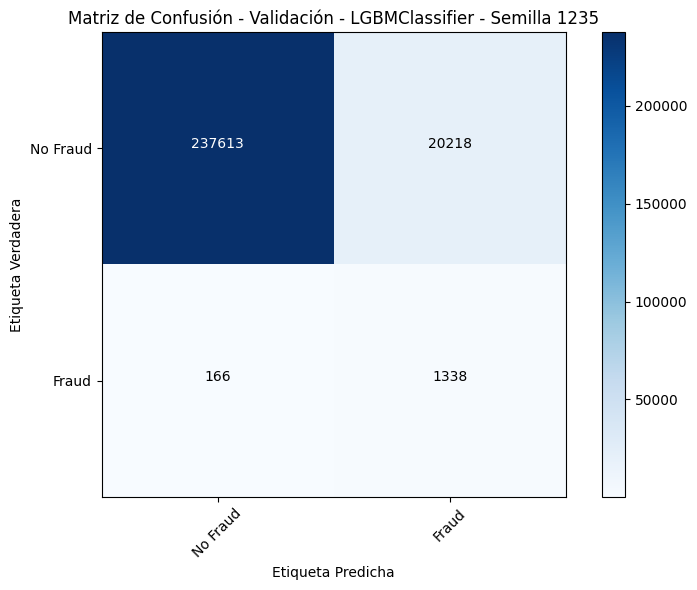

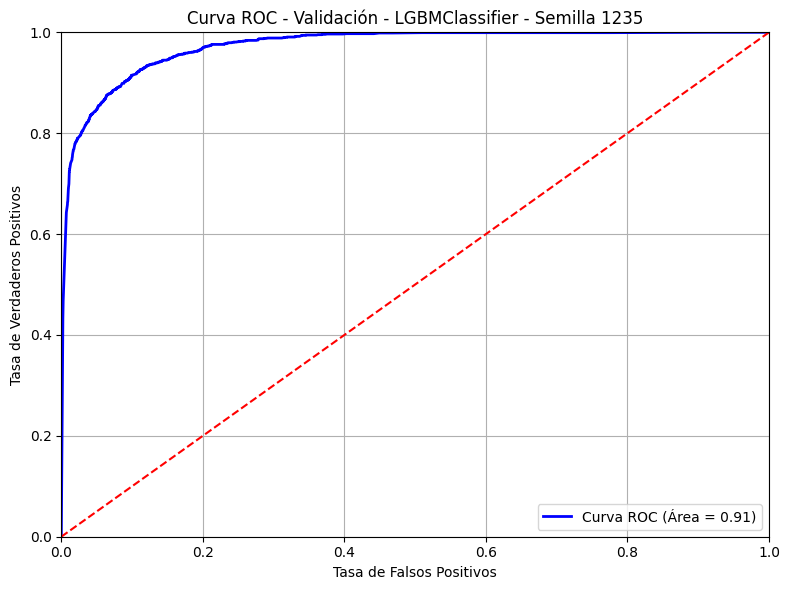


Evaluación final en el conjunto de prueba para LGBMClassifier - Semilla 1235
  LGBMClassifier - undersampling (Semilla 1235)
    Accuracy: 0.9214375228950971
    Precision: 0.06127667488028267
    Recall: 0.8780812791472352
    F1 Score: 0.11455888744024337
    ROC-AUC: 0.8998856018361586
    Best Parameters: {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 31, 'scale_pos_weight': 1}
Modelo guardado como model_LGBMClassifier_undersampling_seed_1235.pkl


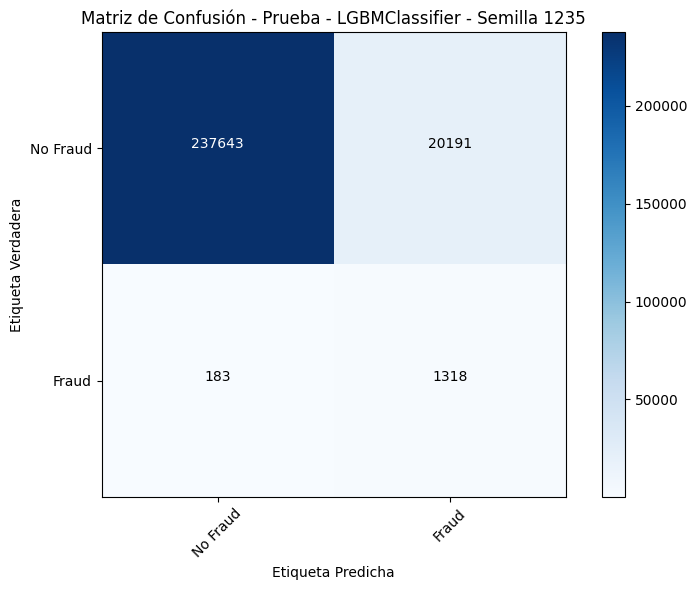

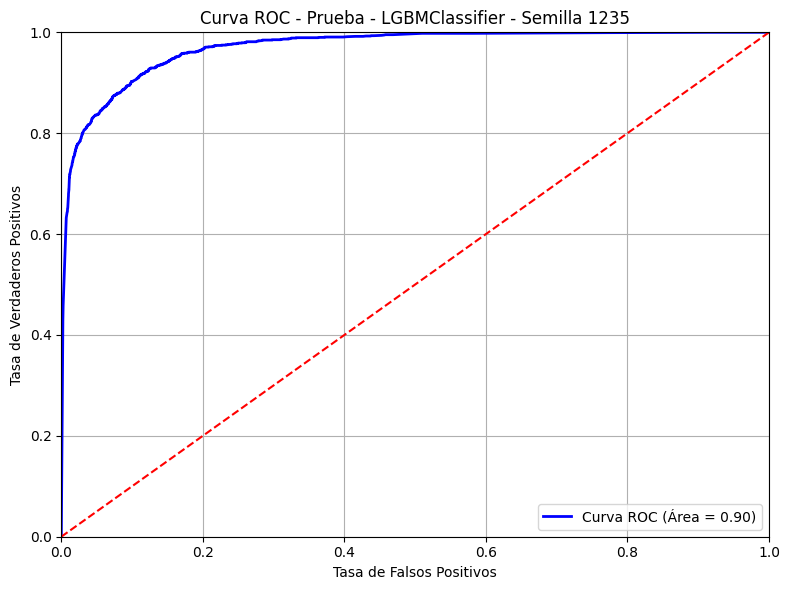

  LGBMClassifier - undersampling (Semilla 1235)
    Accuracy: 0.9214375228950971
    Precision: 0.06127667488028267
    Recall: 0.8780812791472352
    F1 Score: 0.11455888744024337
    ROC-AUC: 0.8998856018361586
    Best Parameters: {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 31, 'scale_pos_weight': 1}
Modelo guardado como model_LGBMClassifier_undersampling_seed_1235.pkl

--> Iniciando undersampling para XGBClassifier con semilla 1235
Tamaño original de X_train: (778005, 4), y_train: (778005,)


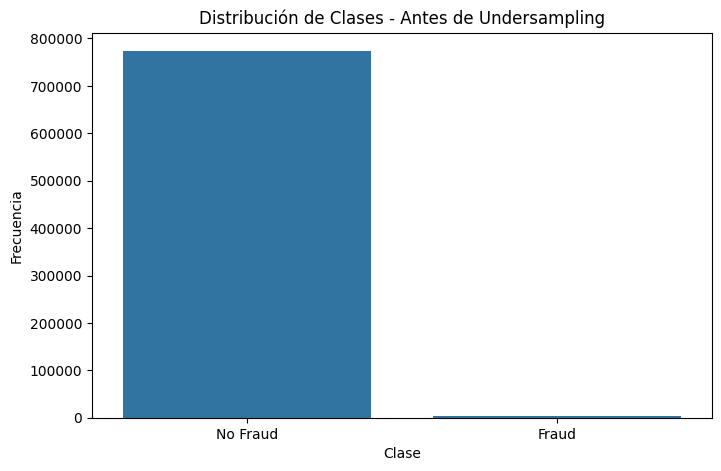

Tamaño después de undersampling de X_train: (9002, 4), y_train: (9002,)


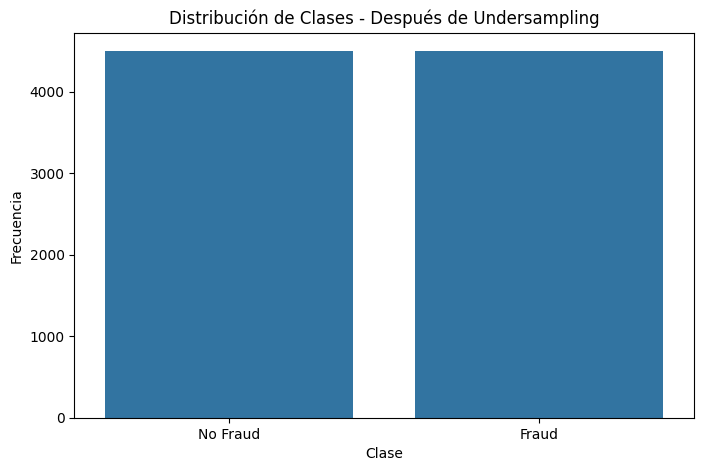


Evaluación en el conjunto de validación para XGBClassifier - Semilla 1235
  XGBClassifier - undersampling (Semilla 1235)
    Accuracy: 0.9231071779744346
    Precision: 0.06353865820747123
    Recall: 0.8922872340425532
    F1 Score: 0.11862983425414364
    ROC-AUC: 0.9077870966649191
    Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1}
Modelo guardado como model_XGBClassifier_undersampling_seed_1235.pkl


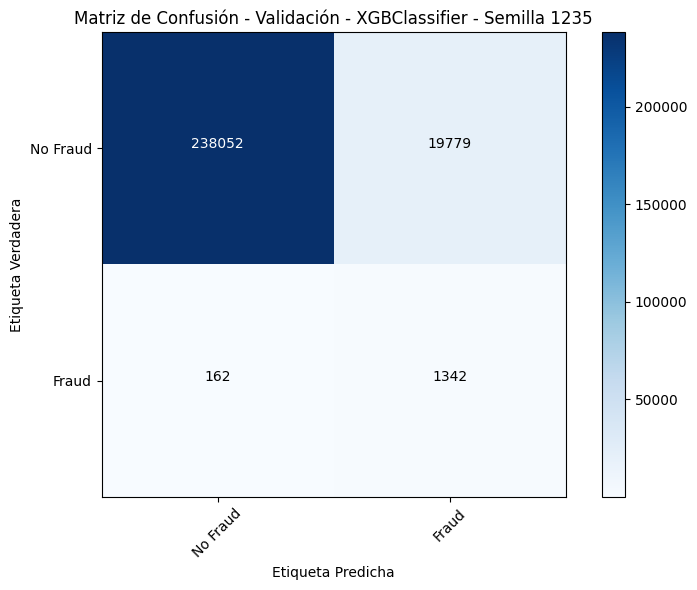

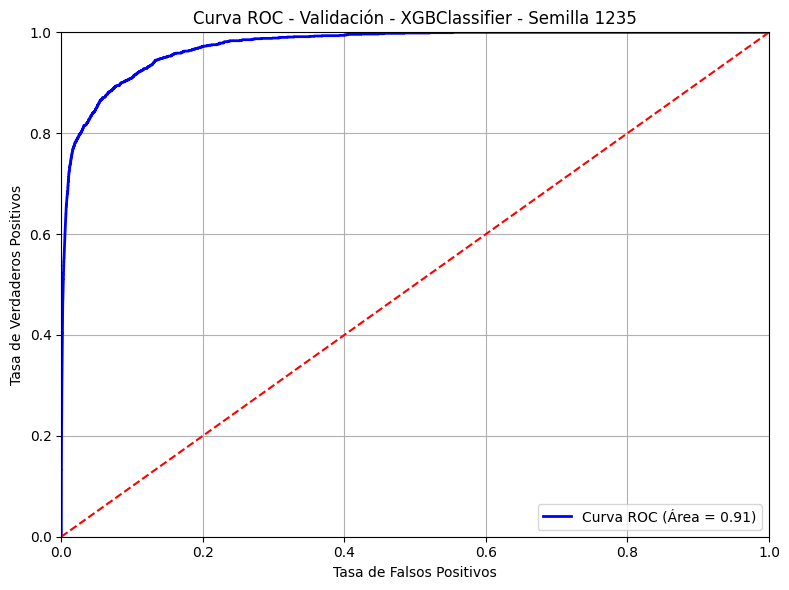


Evaluación final en el conjunto de prueba para XGBClassifier - Semilla 1235
  XGBClassifier - undersampling (Semilla 1235)
    Accuracy: 0.9232305704976189
    Precision: 0.06267224175615319
    Recall: 0.8787475016655563
    F1 Score: 0.11700004435179846
    ROC-AUC: 0.9011185168450186
    Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1}
Modelo guardado como model_XGBClassifier_undersampling_seed_1235.pkl


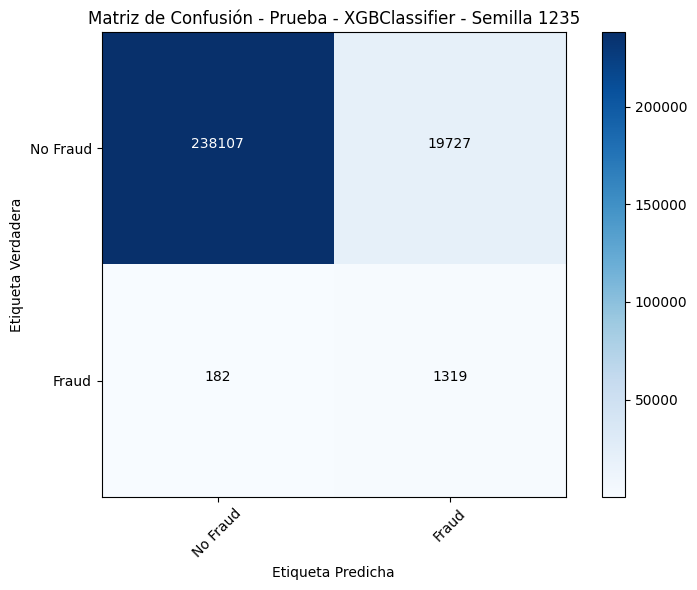

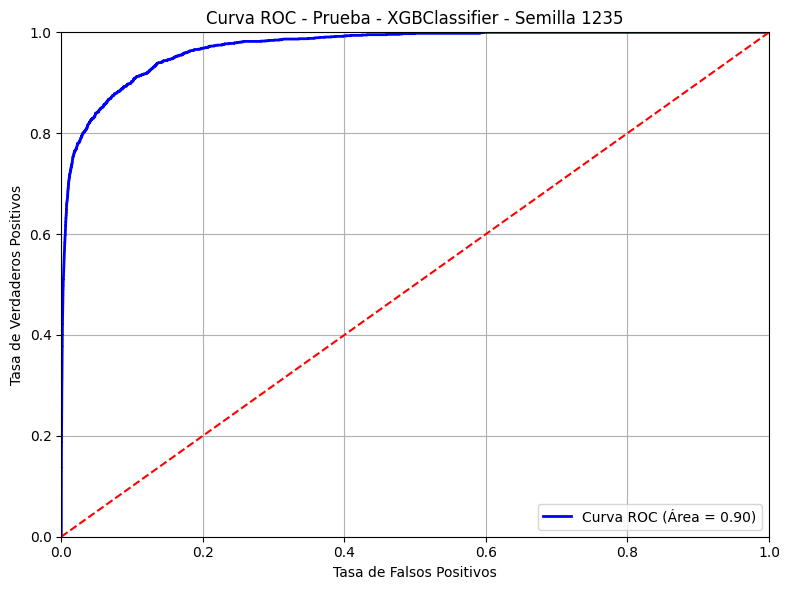

  XGBClassifier - undersampling (Semilla 1235)
    Accuracy: 0.9232305704976189
    Precision: 0.06267224175615319
    Recall: 0.8787475016655563
    F1 Score: 0.11700004435179846
    ROC-AUC: 0.9011185168450186
    Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1}
Modelo guardado como model_XGBClassifier_undersampling_seed_1235.pkl

--> Iniciando undersampling para CatBoostClassifier con semilla 1235
Tamaño original de X_train: (778005, 4), y_train: (778005,)


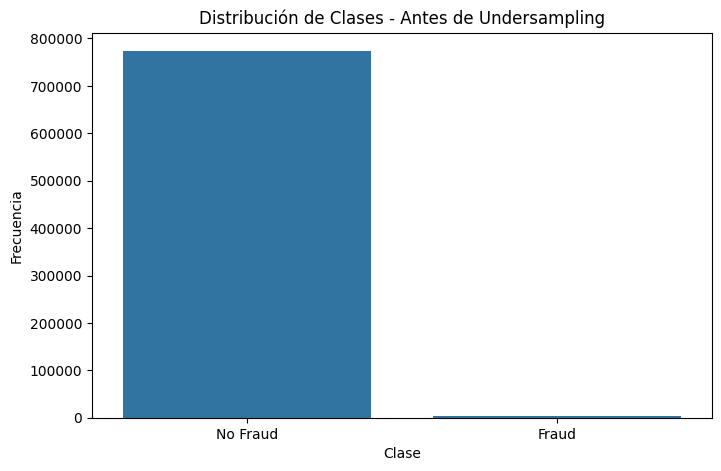

Tamaño después de undersampling de X_train: (9002, 4), y_train: (9002,)


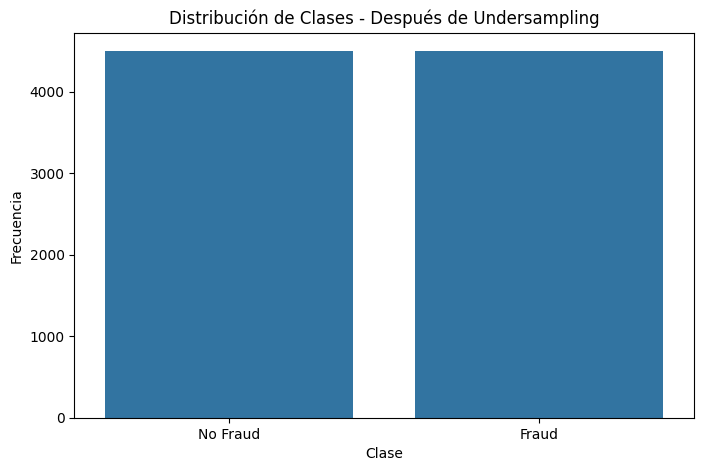


Evaluación en el conjunto de validación para CatBoostClassifier - Semilla 1235
  CatBoostClassifier - undersampling (Semilla 1235)
    Accuracy: 0.9192820097557214
    Precision: 0.060886859829137094
    Recall: 0.8956117021276596
    F1 Score: 0.11402209336775723
    ROC-AUC: 0.90751589368865
    Best Parameters: {'depth': 4, 'iterations': 200, 'learning_rate': 0.1}
Modelo guardado como model_CatBoostClassifier_undersampling_seed_1235.pkl


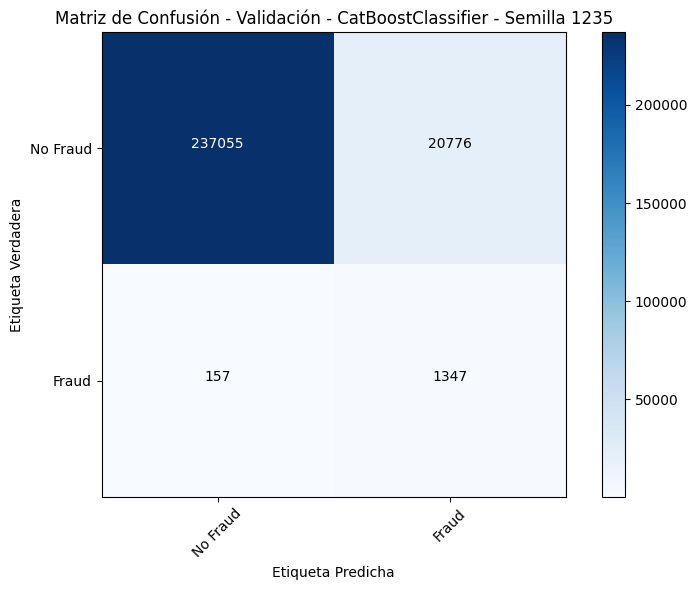

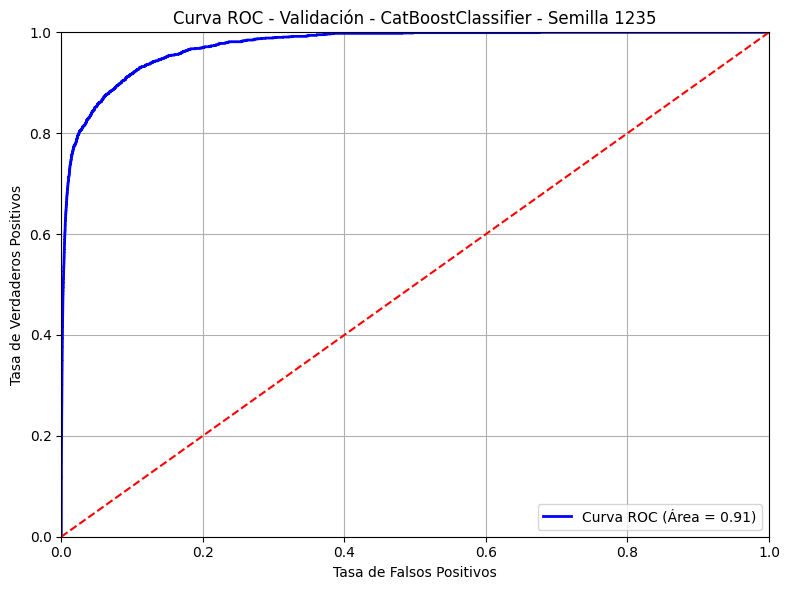


Evaluación final en el conjunto de prueba para CatBoostClassifier - Semilla 1235
  CatBoostClassifier - undersampling (Semilla 1235)
    Accuracy: 0.9193938342298571
    Precision: 0.06036162595731182
    Recall: 0.8874083944037309
    F1 Score: 0.11303462321792261
    ROC-AUC: 0.9034942171371727
    Best Parameters: {'depth': 4, 'iterations': 200, 'learning_rate': 0.1}
Modelo guardado como model_CatBoostClassifier_undersampling_seed_1235.pkl


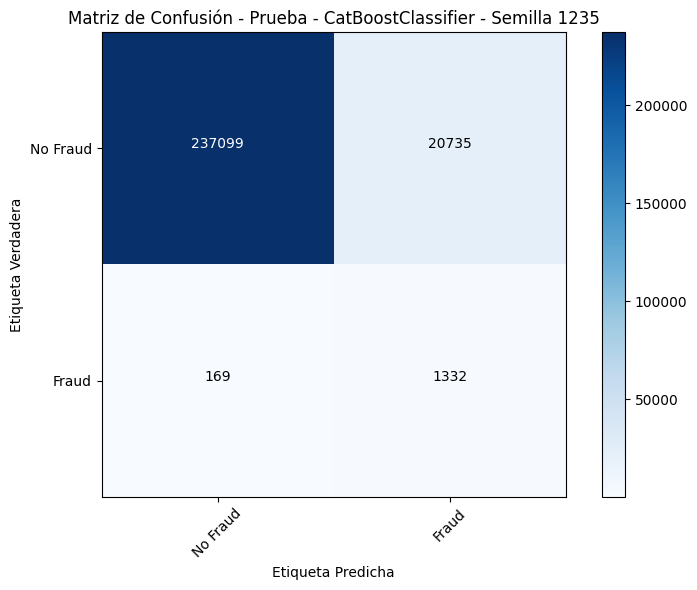

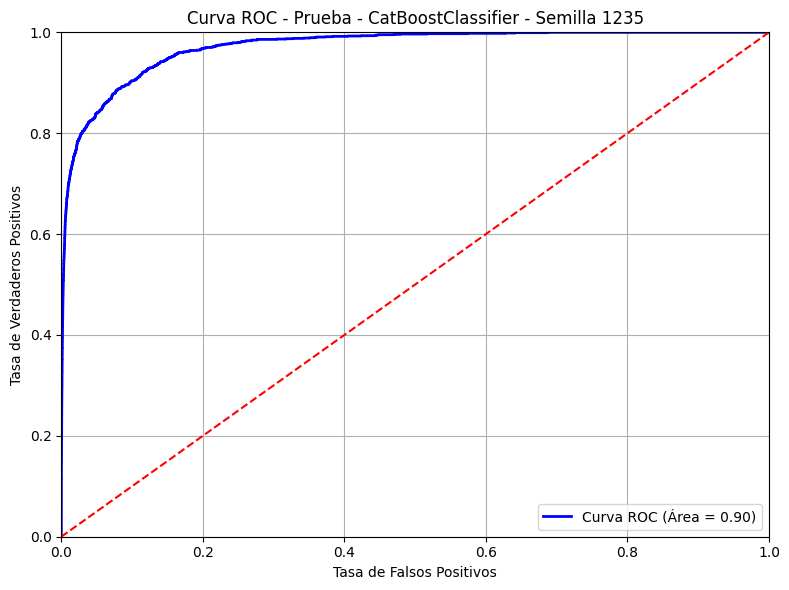

  CatBoostClassifier - undersampling (Semilla 1235)
    Accuracy: 0.9193938342298571
    Precision: 0.06036162595731182
    Recall: 0.8874083944037309
    F1 Score: 0.11303462321792261
    ROC-AUC: 0.9034942171371727
    Best Parameters: {'depth': 4, 'iterations': 200, 'learning_rate': 0.1}
Modelo guardado como model_CatBoostClassifier_undersampling_seed_1235.pkl

--> Iniciando undersampling para LogisticRegression con semilla 10101101
Tamaño original de X_train: (778005, 4), y_train: (778005,)


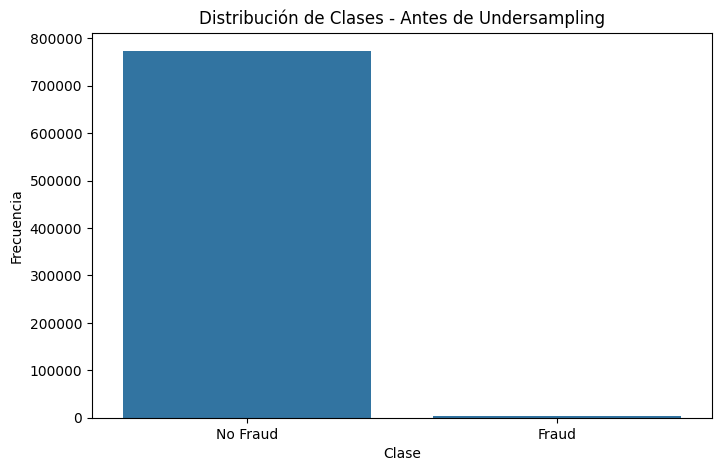

Tamaño después de undersampling de X_train: (9140, 4), y_train: (9140,)


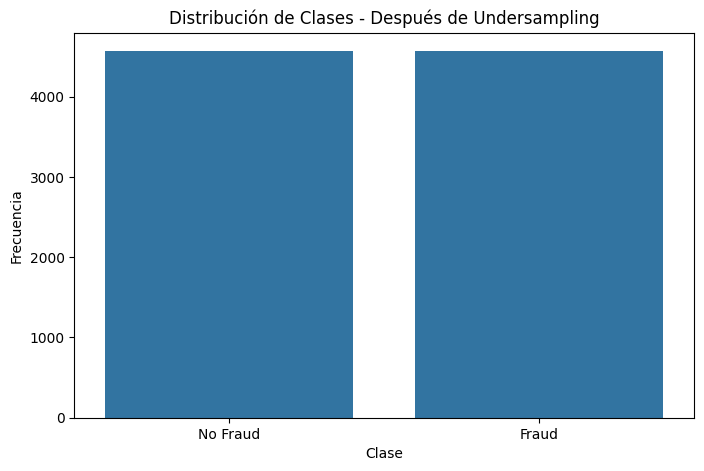


Evaluación en el conjunto de validación para LogisticRegression - Semilla 10101101
  LogisticRegression - undersampling (Semilla 10101101)
    Accuracy: 0.9574642836485626
    Precision: 0.0961408259986459
    Recall: 0.7639542703429725
    F1 Score: 0.1707885439374577
    ROC-AUC: 0.8612672595858699
    Best Parameters: {'C': 0.01}
Modelo guardado como model_LogisticRegression_undersampling_seed_10101101.pkl


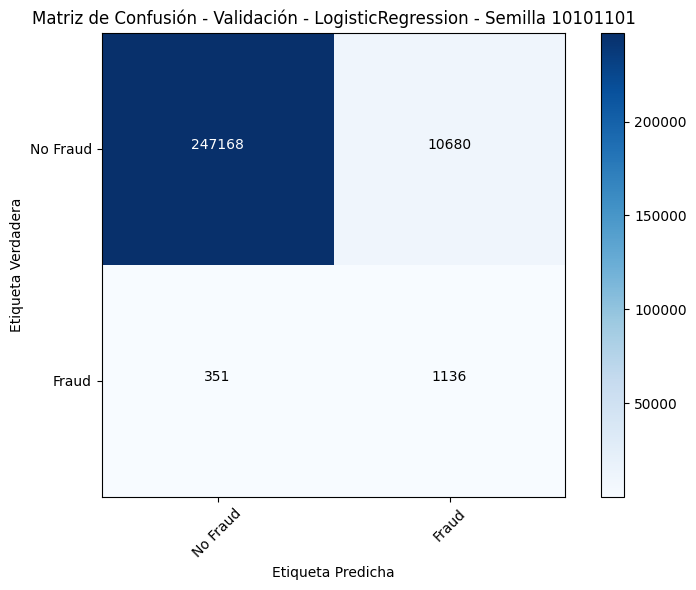

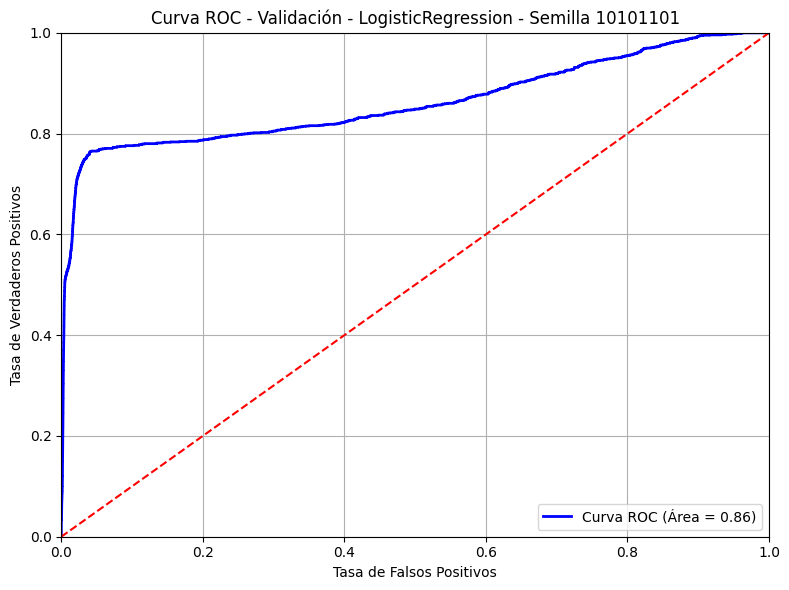


Evaluación final en el conjunto de prueba para LogisticRegression - Semilla 10101101
  LogisticRegression - undersampling (Semilla 10101101)
    Accuracy: 0.9568203289181946
    Precision: 0.09396084964598084
    Recall: 0.7784679089026915
    F1 Score: 0.16768247361379515
    ROC-AUC: 0.8681451787907825
    Best Parameters: {'C': 0.01}
Modelo guardado como model_LogisticRegression_undersampling_seed_10101101.pkl


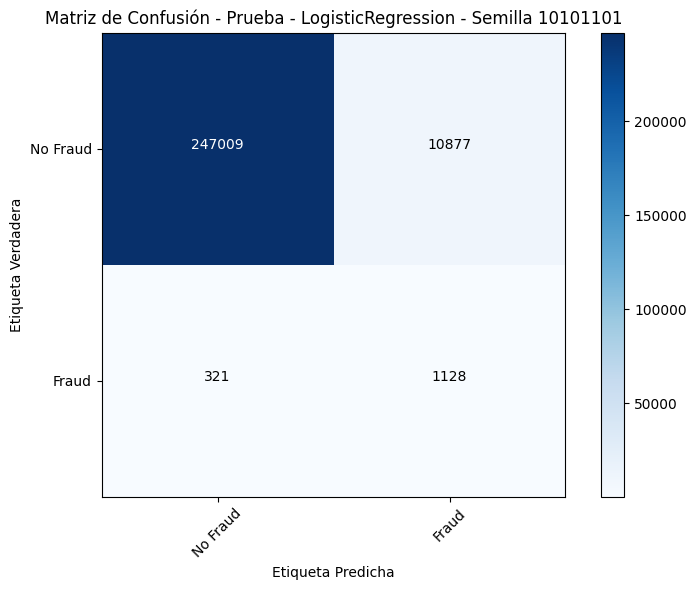

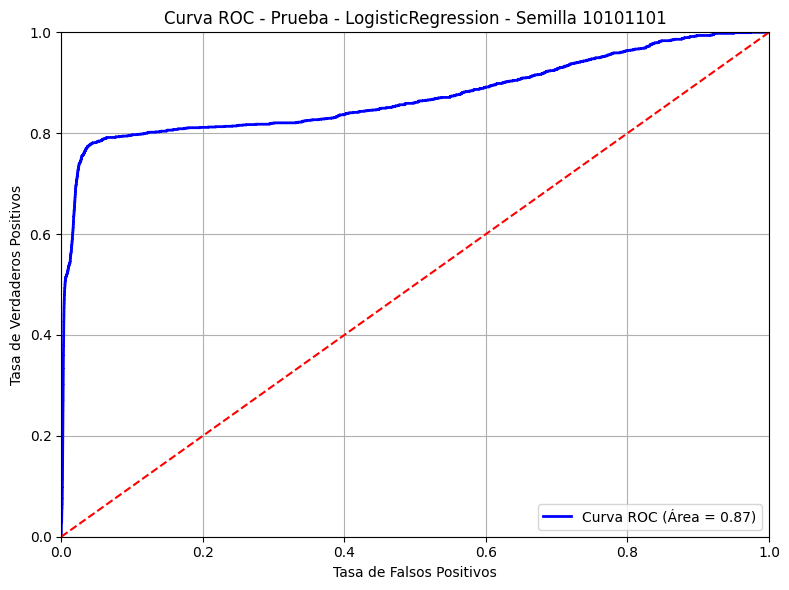

  LogisticRegression - undersampling (Semilla 10101101)
    Accuracy: 0.9568203289181946
    Precision: 0.09396084964598084
    Recall: 0.7784679089026915
    F1 Score: 0.16768247361379515
    ROC-AUC: 0.8681451787907825
    Best Parameters: {'C': 0.01}
Modelo guardado como model_LogisticRegression_undersampling_seed_10101101.pkl

--> Iniciando undersampling para DecisionTreeClassifier con semilla 10101101
Tamaño original de X_train: (778005, 4), y_train: (778005,)


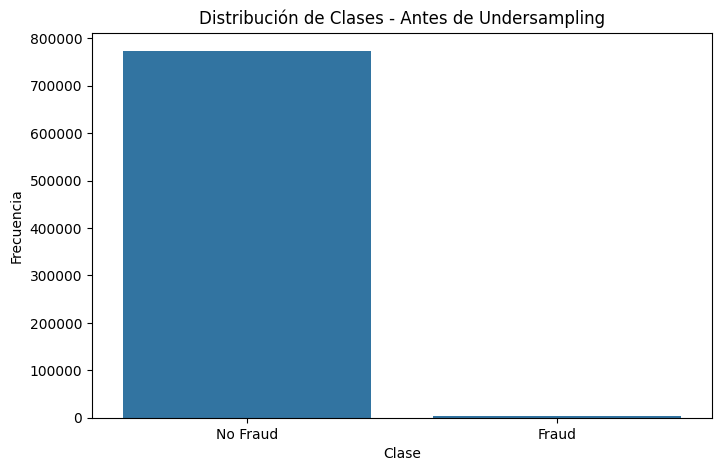

Tamaño después de undersampling de X_train: (9140, 4), y_train: (9140,)


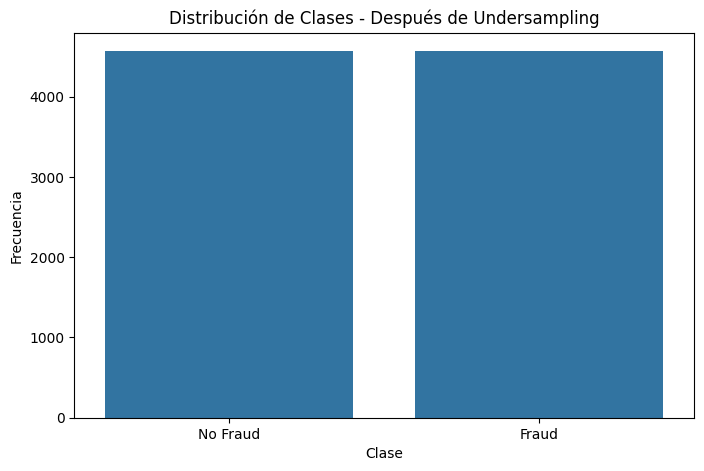


Evaluación en el conjunto de validación para DecisionTreeClassifier - Semilla 10101101
  DecisionTreeClassifier - undersampling (Semilla 10101101)
    Accuracy: 0.8955019569282974
    Precision: 0.04681694327470894
    Recall: 0.8897108271687962
    F1 Score: 0.08895313655617562
    ROC-AUC: 0.8926230906654691
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Modelo guardado como model_DecisionTreeClassifier_undersampling_seed_10101101.pkl


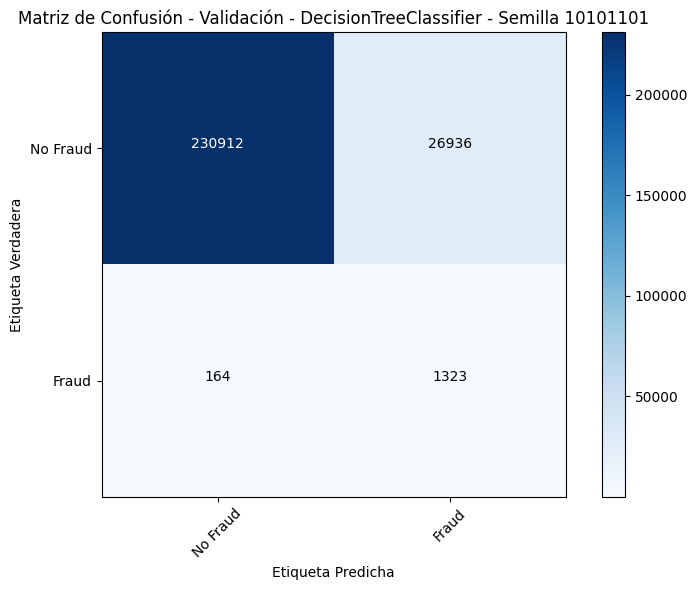

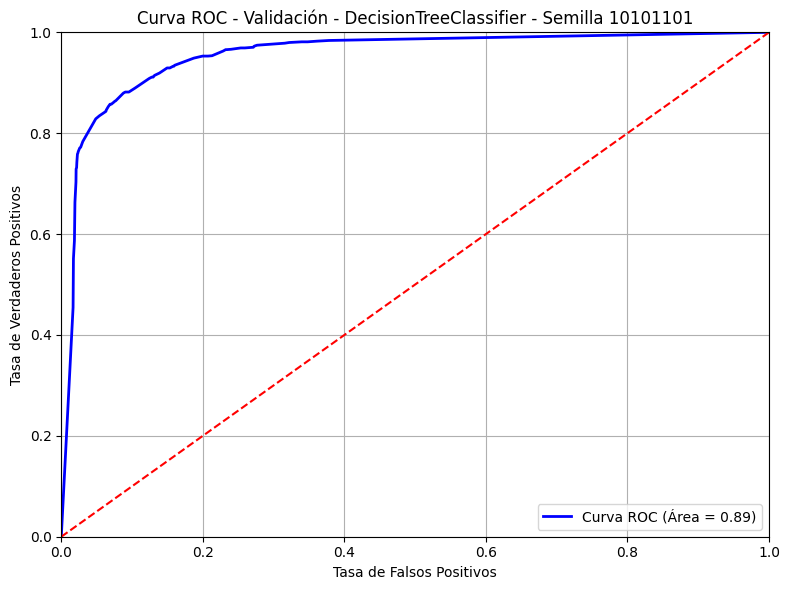


Evaluación final en el conjunto de prueba para DecisionTreeClassifier - Semilla 10101101
  DecisionTreeClassifier - undersampling (Semilla 10101101)
    Accuracy: 0.8952821639963754
    Precision: 0.04547383309759547
    Recall: 0.8875086266390614
    F1 Score: 0.08651485081906556
    ROC-AUC: 0.8914172341450117
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Modelo guardado como model_DecisionTreeClassifier_undersampling_seed_10101101.pkl


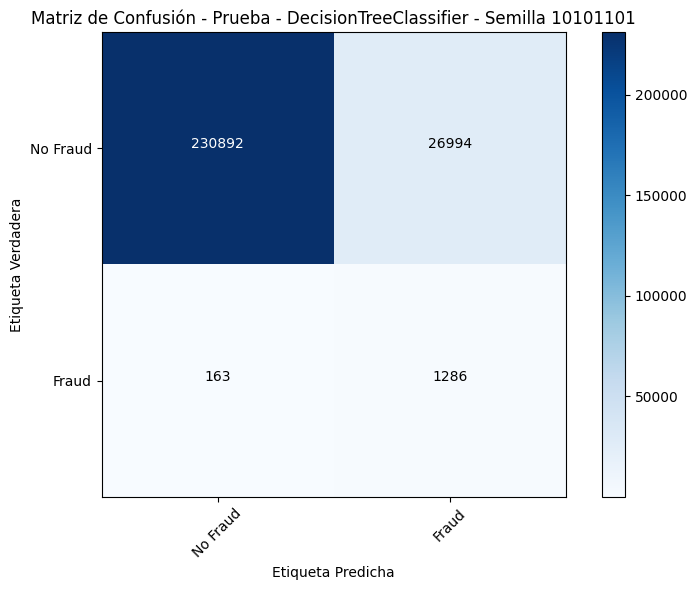

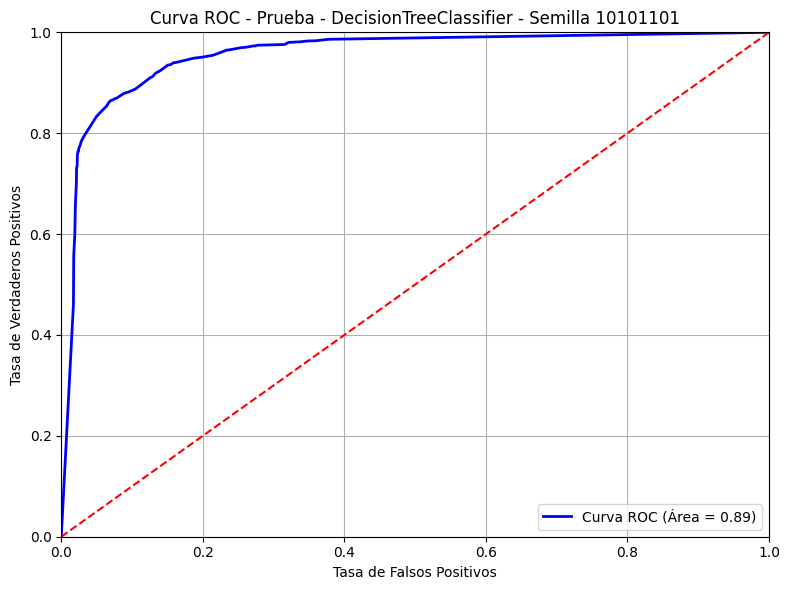

  DecisionTreeClassifier - undersampling (Semilla 10101101)
    Accuracy: 0.8952821639963754
    Precision: 0.04547383309759547
    Recall: 0.8875086266390614
    F1 Score: 0.08651485081906556
    ROC-AUC: 0.8914172341450117
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Modelo guardado como model_DecisionTreeClassifier_undersampling_seed_10101101.pkl

--> Iniciando undersampling para RandomForestClassifier con semilla 10101101
Tamaño original de X_train: (778005, 4), y_train: (778005,)


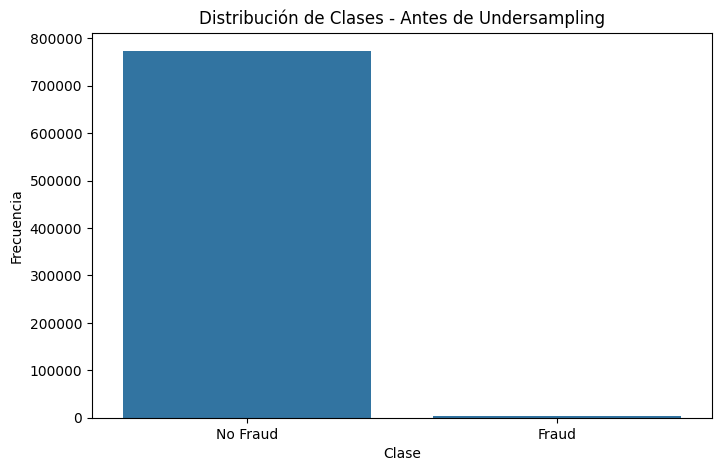

Tamaño después de undersampling de X_train: (9140, 4), y_train: (9140,)


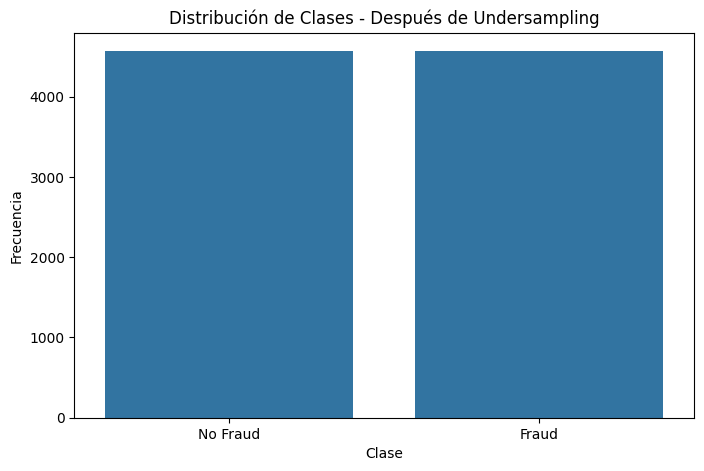

In [ ]:
models_and_params = [
    (LogisticRegression(max_iter=2000), {'C': [0.001, 0.01, 0.1, 1, 10, 100]}),
    (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    # Modelos con scale_pos_weight
    (LGBMClassifier(), {'num_leaves': [31, 50, 100], 'max_depth': [-1, 10, 20], 'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [100, 200], 'scale_pos_weight': [1, 10, 20]}),
    (XGBClassifier(eval_metric='mlogloss', use_label_encoder=False), {'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [100, 200], 'scale_pos_weight': [1, 10, 20]}),
    (CatBoostClassifier(silent=True), {'depth': [4, 6, 8], 'learning_rate': [0.01, 0.1], 'iterations': [100, 200]})
]

for seed in seed_list:
    X_train_val, X_test, y_train_val, y_test = train_test_split(features, target, test_size=0.2, random_state=seed)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=seed)
    
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_val_transformed = preprocessor.transform(X_val)
    X_test_transformed = preprocessor.transform(X_test)
    
    for model_class, param_grid in models_and_params:
        model_name = model_class.__class__.__name__

        if model_name == 'CatBoostClassifier':
            model_class = CatBoostClassifier(silent=True, random_seed=seed)
            param_grid.pop("random_seed", None)

        results_undersampling = grid_search_with_and_without_balance(
            model_class, param_grid, X_train_transformed, y_train,
            X_val_transformed, y_val, X_test_transformed, y_test, 
            sampler=SamplingMethod.UNDERSAMPLING, random_seed=seed, 
            balance_type='undersampling'
        )
        print_results(results_undersampling, model_name, 'undersampling', seed)